In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
#Configure Defaults
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
from tqdm import tqdm_notebook

plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

Spherical k-means for document clustering
- https://lovit.github.io/nlp/machine%20learning/2018/10/16/spherical_kmeans/

In [2]:
def summary(df) :
    pd.set_option('display.max_rows', 100)
    tf = pd.DataFrame({'데이터형태(dtypes)' : df.dtypes, 
                        '비 결측치 수(notnull' : df.notnull().sum(),
                        '결측치 수(null)' : df.isnull().sum(), 
                        '고유값 수(nunique)' : df.nunique()})
    return tf

In [3]:
df = pd.read_pickle('../data/result.pkl')
# 제목이 같은 항목 삭제 및 마지막 레코드만 남김
df = df.drop_duplicates(subset=['일자','언론사', '본문'], keep="last")
df = df.dropna(subset=['특성추출(가중치순 상위 50개)'], axis=0)
df['일자'].max(); df['일자'].min()
df.head()
df.shape

Timestamp('2022-02-28 00:00:00')

Timestamp('2017-01-01 00:00:00')

,일자,언론사,통합 분류1,통합 분류2,통합 분류3,키워드,특성추출(가중치순 상위 50개),본문
8674,2020-03-20,중도일보,경제>자원,경제>유통,지역>경남,"순수,국산,수매,밀가루,시범,판매,농산물,면역,증진,효과,노화,억제,한국농수산식품유...","시범판매,밀가루,농산물,밀산업,자급률,병해충,소비자,육성법,소비량,신규제품,16톤,...","한국농수산식품유통공사(aT, 사장 이병호)는 지난해 수매한 국산 밀가루 16톤을 오..."
8675,2020-03-20,중도일보,지역>전북,지역>전남,지역>강원,"물고기,채소농사,고창군,아쿠아포닉스,채소,전국,출하,아쿠아포닉스,농법,착공,시설,출...","아쿠아포닉스,고창군,고창군청,지원사업,이영성,아쿠아포닉스코리아,재배법,수경재배,환경...",전북 고창군의 한 농장이 물고기 양식장에서 나온 유기물로 작물을 재배하는 '아쿠아포...
8678,2020-03-20,전북도민일보,지역>충북,지역>대전,지역>전북,"남부안농협,토양,개량제,무상,지원,남부안농협,조합장,최우식,로컬,푸드,농산물,생산,...","남부안농협,로컬푸드,토양개량제,직매장,농산물,고품질,무상지원,농가소득,732포,최우...",남부안농협(조합장 최우식)은 로컬푸드 고품질 농산물 생산을 위한 토양개량 지원사업...
8687,2020-03-20,충청투데이,경제>유통,경제>자원,NaN,"취나물,부여,백마강,부여군농업기술센터,남면,지역,백마강,취나물,출하,본격적,시작,1...","면역력,백마강,부여군,관계자,부여군농업기술센터,병해충,클로로젠산,농약허용물질목록관리...",[충청투데이 김일순 기자] 부여군농업기술센터는 남면 지역에서 고품질 백마강 취나물 ...
8689,2020-03-19,대전일보,지역>경기,지역>충남,경제>자원,"보령시,공모,타작물,생산,장비,지원,사업,보령,보령시,타작물,재배,확산,타작물,재배...","타작물,보령시,농업인,간척지,ha,연명부,소재지,기반정비,선별기,방제기,수확기,농기...",[보령] 보령시는 논 타작물 재배 확산을 위해 타작물 재배에 필요한 기반정비 및 생...


(570265, 8)

## 불용어 

In [4]:
data1 = pd.read_excel('../data/출현단어_5만 _박태욱.xlsx')
data2 = pd.read_excel('../data/출현단어_10만_권성희.xlsx')

data3 = pd.read_excel('../data/출현단어_15만_박태욱.xlsx')
data4 = pd.read_excel('../data/출현단어_20만_권성희.xlsx')
data = data1.append(data2).append(data3).append(data4)
data.shape

stop_words_01 = data[data['선택'] == 0]['출현단어'].tolist()
print('채택단어', len(data[data['선택'] == 1]))
print('불용어비율', len(data[data['선택'] == 0])/len(data)*100)
stop_words = list(set(stop_words_01))

for i in df.언론사.value_counts().index :
    stop_words.append(i)
for i in ['미국', '국내', '한국', '대표', '중국','일본', '가격', '글로벌', '기업', '대상', '정부', '세계', '국회', '관심', '방송'] :
    stop_words.append(i)
for i in ['인사', '발령', '공개모집', '필기시험', '발령', '인사 발령', '과장', '전보', '일자', '공무원', '국장', '점검', '실시'] :
    stop_words.append(i)
common = ["전략", "연구", "평가", "마련", "조사", "관리", "보다", "관련","전문가","예정","이번", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
          "총회", "대한", "통해", "한국","국내","개최","행사","우수","장관","피해","해외","일자리","박람회", "지원", "위해", "총회","국제","분야","세계",
          "식품과학","국립","시민","통합", "정책", "대해", '선정', '아시아경제']
for i in common :
    stop_words.append(i)
for i in ['두고', '농협', '시행', '식품안전', '안전', '참여', '이상', '조치', '개선', '관내', '참석', '대전', '확산', '조성', '홍보'] :
    stop_words.append(i)
for i in ['대한민국', '홈페이지', '상반기', '시간date', '이명박', '박근혜', '청와대', '위원회',
          '그동안', '1만', '회용', '사람들', '앤서니', '이재명', '더불어민주당', '민주당',
         '봉준호', '시상식', '만큼','위원장', '관계자', '서울', '국민의힘', '윤석열', 'a씨', '식품의약품안전처', '식약처','소비자들', '농림축산식품부',
         '식품부', '농식품부', '소비자', '용가리',
         '의약품',
          '의약국', '제약사', '농협중앙회',
          '피임약', '항정신성의약품', '탈모약', '제품', '식품',
        #  '농산물', '축산물', '수산물',
         ]:
    stop_words.append(i)
#for i in ['호르몬', '호르몬제', '환경호르몬', '성장호르몬', '의약국', '바나나맛']:
#    stop_words.append(i)

len(list(set(stop_words)))
stop_words = list(set(stop_words))

(200000, 4)

채택단어 16133
불용어비율 91.93050000000001


183901

##  Stopwords 확인

In [5]:
sf=pd.DataFrame()
for i in np.arange(0, 100):
    #(i*100, (i+1)*100)
    sf = sf.append(pd.DataFrame([stop_words[i*100+1 :(i+1)*100]]))
sf.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,산업혁신운동,정규군,뒷범퍼,파비안느,2b급,bl,최대토크,친숙도,입금계좌,창업마루,...,정치력,소감문,위탁운용사,출입국사무소,공급업체,deg,산란계,지방법원,약화,류마티스
0,명예살인,종합편성,ktl,형사8부,두류공원야구장,kbl,환경주,감축분,전담운영자,고리1호,...,차이홍,수감중,조직적,사기의심,위건위,골든벨,승리자,5517건,오인광고,가맹업소
0,김동관,가로띠,아기욕조,한센인,한영수,정형외과장,통상임금,구강내과,결제망,위험인자들,...,쪽지,조제약국,270만,출입경,녹래리,인구주택총,졸업후,적용여부,솔방울샘,황형주
0,병영차트,전재욱,개통예정,달님,계명대,규제기관,고온스,기획재정담당관,핀테크,중등교육법,...,물류통신단말기,독서마라톤대회,러캐머라,cheers,잉카,놀이맵,결정질,로이,화순읍,각하
0,클랜,박항서,중개업계,공공급식지원센터,자기주장,상주보호자,제작시스템,기업회원,별풍선,퓨마,...,체인지엑스,원예산업학부,발육,예수님,건강증진과,박보성기자,연구개발력,적재장,에코맘,수목훼손


# 제2절 코로나 전후의 출현 단어 비교 분석
## 단순분석

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer

# 시작년도, 끝년도 지정
start_year = 2017
end_year = 2022

corpus = [""] * len(df)

result_df = pd.DataFrame()

# 녇도별 문서 추출 후 키워드 빈도수 분석

for year in tqdm_notebook(range(int(start_year),int(end_year)+1)):
    start_date = str(year) + "-01-01"
    end_date = str(year) + "-12-31"
    dt_index = (df['일자'] >= start_date) & (df['일자'] <= end_date)
    temp_df = df[dt_index]

    # twitter 단어 추출이 필요없음
    #for i, fn in enumerate(temp_df['특성추출(가중치순 상위 50개)']) :
    #    corpus[i] = " ".join(twitter.nouns(fn))
    
    corpus = []
    for keywords in temp_df['특성추출(가중치순 상위 50개)']:
        corpus.append(keywords)    
       
        
    vect = CountVectorizer(stop_words = stop_words, ngram_range=(1, 1), min_df= 0.005, max_df= 0.8)
    X = vect.fit_transform(corpus)
    X = TfidfTransformer().fit_transform(X)
        
    count = X.toarray().sum(axis=0)
    idx = np.argsort(-count)
    count = count[idx]

    feature_name = np.array(vect.get_feature_names())[idx]

    result = list(zip(feature_name, count))
    result = pd.DataFrame(result)
    result.columns=[str(year) + ' 키워드','빈도수']
    result_df = pd.concat([result_df,result],axis=1)
    
result_df.head(20)

  0%|          | 0/6 [00:00<?, ?it/s]

,2017 키워드,빈도수,2018 키워드,빈도수,2019 키워드,빈도수,2020 키워드,빈도수,2021 키워드,빈도수,2022 키워드,빈도수
0,중금속,895.417813,발암물질,1165.768685,중금속,1588.261052,온라인,5492.078944,온라인,15501.429421,온라인,5482.389246
1,발암물질,683.855502,중금속,1146.458796,온라인,1271.568948,농산물,2877.900931,농산물,10938.090216,농산물,2521.833248
2,곰팡이,502.664353,건강기능식품,787.428157,오염수,1214.989529,축산물,2246.209998,수산물,5711.243791,소상공인,1796.345251
3,대장균,455.258745,곰팡이,726.635917,건강기능식품,1092.587858,안전성,1777.214508,오염수,4408.683665,수산물,958.928095
4,첨가물,422.924461,온라인,668.405068,곰팡이,1084.159737,수산물,1571.839465,안전성,4199.421435,친환경,924.133291
5,유해물질,370.477287,첨가물,601.947579,농산물,963.228346,면역력,1448.446352,소상공인,3506.941706,농업인,910.642951
6,온라인,352.007125,대장균,555.083712,발암물질,850.632853,농업인,1359.075094,친환경,3061.370227,안전성,844.719219
7,안전성,331.586520,단백질,531.729427,안전성,804.213954,대장균,1314.801798,음식점,3001.117444,음식점,670.378789
8,화합물,259.035310,농산물,514.883763,단백질,760.242491,단백질,1289.918435,농업인,2928.842096,단백질,665.087385
9,농산물,258.564359,안전성,467.305417,건강,728.680722,건강기능식품,1237.917298,축산물,2921.167388,건강,538.653224


In [7]:
result_df.head(11)

,2017 키워드,빈도수,2018 키워드,빈도수,2019 키워드,빈도수,2020 키워드,빈도수,2021 키워드,빈도수,2022 키워드,빈도수
0,중금속,895.417813,발암물질,1165.768685,중금속,1588.261052,온라인,5492.078944,온라인,15501.429421,온라인,5482.389246
1,발암물질,683.855502,중금속,1146.458796,온라인,1271.568948,농산물,2877.900931,농산물,10938.090216,농산물,2521.833248
2,곰팡이,502.664353,건강기능식품,787.428157,오염수,1214.989529,축산물,2246.209998,수산물,5711.243791,소상공인,1796.345251
3,대장균,455.258745,곰팡이,726.635917,건강기능식품,1092.587858,안전성,1777.214508,오염수,4408.683665,수산물,958.928095
4,첨가물,422.924461,온라인,668.405068,곰팡이,1084.159737,수산물,1571.839465,안전성,4199.421435,친환경,924.133291
5,유해물질,370.477287,첨가물,601.947579,농산물,963.228346,면역력,1448.446352,소상공인,3506.941706,농업인,910.642951
6,온라인,352.007125,대장균,555.083712,발암물질,850.632853,농업인,1359.075094,친환경,3061.370227,안전성,844.719219
7,안전성,331.586520,단백질,531.729427,안전성,804.213954,대장균,1314.801798,음식점,3001.117444,음식점,670.378789
8,화합물,259.035310,농산물,514.883763,단백질,760.242491,단백질,1289.918435,농업인,2928.842096,단백질,665.087385
9,농산물,258.564359,안전성,467.305417,건강,728.680722,건강기능식품,1237.917298,축산물,2921.167388,건강,538.653224


# 코로나 전후 데이터 분석

In [8]:
df.shape

(570265, 8)

# 코로나 전후 지정, 1은 코로나 이후 0은 코로나 발생 이전

In [9]:
base_date = '2020-01-20'

df['코로나전후'] = 1
df.loc[df['일자'] < base_date, '코로나전후'] = 0
print('코로나 전 최대 일자는')
df[df['코로나전후'] == 0]['일자'].max()

코로나 전 최대 일자는


Timestamp('2020-01-19 00:00:00')

In [10]:
corpus = [""] * len(df)

result_df = pd.DataFrame()

# 녇도별 문서 추출 후 키워드 빈도수 분석

for corona in tqdm_notebook(range(2)):
    
    temp_df = df[df['코로나전후'] == corona]
    
    corpus = []
    for keywords in temp_df['특성추출(가중치순 상위 50개)']:
        corpus.append(keywords)    
       
        
    vect = CountVectorizer(stop_words = stop_words, ngram_range=(1, 1), min_df= 0.00025, max_df= 0.9)
    X = vect.fit_transform(corpus)
    X = TfidfTransformer().fit_transform(X)
        
    count = X.toarray().sum(axis=0)
    idx = np.argsort(-count)
    count = count[idx]

    feature_name = np.array(vect.get_feature_names())[idx]

    result = list(zip(feature_name, count))
    result = pd.DataFrame(result)
    result.columns=['코로나_' + str(corona) + ' 키워드', '빈도수']
    result_df = pd.concat([result_df,result],axis=1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
data = result_df.fillna(0)
data.columns = ['코로나_전 단어', '빈도_전', '코로나_후 단어', '빈도_후']
data.head(20)

,코로나_전 단어,빈도_전,코로나_후 단어,빈도_후
0,중금속,2793.691409,온라인,22053.354266
1,발암물질,2155.111031,농산물,9714.000696
2,곰팡이,1840.513985,안전성,5574.755756
3,온라인,1824.207770,소상공인,5507.711056
4,건강기능식품,1463.391081,수산물,5491.143453
5,안전성,1256.276615,오염수,5084.976309
6,오염수,1254.288350,친환경,3849.380059
7,농산물,1119.365202,축산물,3795.481719
8,유해물질,1048.064045,단백질,3270.995310
9,첨가물,1013.837266,음식점,3126.612908


In [12]:
before = set(data.head(20)['코로나_전 단어'])
after = set(data.head(20)['코로나_후 단어'])
before - after
after- before
after & before

{'대장균', '발암물질', '유해물질', '지하수', '첨가물', '추출물', '화합물'}

{'건강관리', '농식품', '농업인', '소상공인', '식중독', '음식점', '축산물'}

{'건강',
 '건강기능식품',
 '곰팡이',
 '농산물',
 '단백질',
 '면역력',
 '미생물',
 '수산물',
 '안전성',
 '오염수',
 '온라인',
 '중금속',
 '친환경'}

<AxesSubplot:xlabel='코로나_전 단어'>

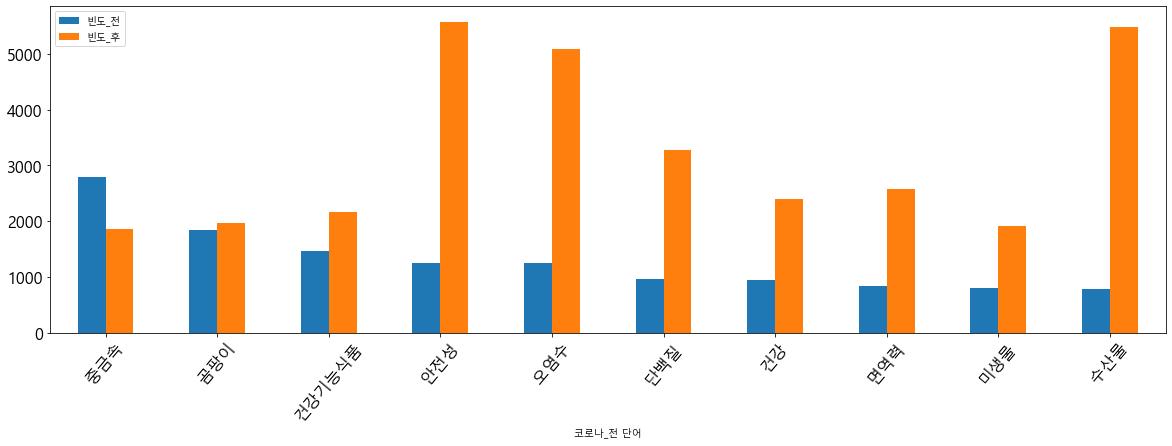

In [13]:
compare = data.head(20)[data.head(20)['코로나_후 단어'].isin(after & before)]

data_01 = compare[['코로나_전 단어', '빈도_전']]
data_02 = compare[['코로나_후 단어', '빈도_후']]

data1 = data_01.merge(data_02, left_on ='코로나_전 단어', right_on ='코로나_후 단어').drop('코로나_후 단어', axis=1)
data1.set_index('코로나_전 단어').plot(kind='bar', rot=50, figsize=(20,6), fontsize=16)

## 1. 코로나 발생이후 사라진 단어

733

<AxesSubplot:xlabel='코로나_전 단어'>

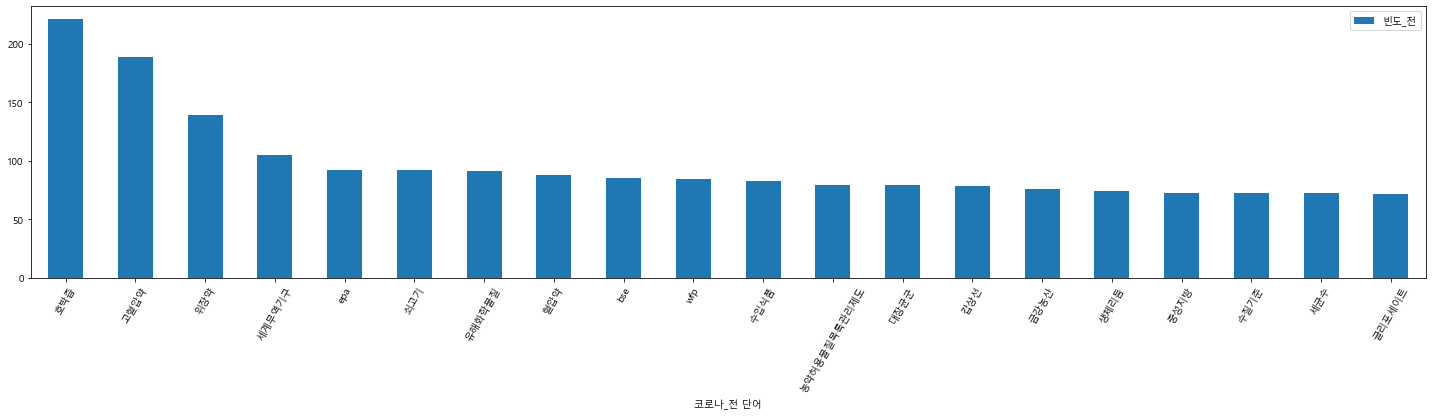

In [14]:
len(set(data['코로나_전 단어'].unique()) - set(data['코로나_후 단어'].unique()))
cor01_list = set(data['코로나_전 단어'].unique()) - set(data['코로나_후 단어'].unique())
data[data['코로나_전 단어'].isin(cor01_list)][['코로나_전 단어', '빈도_전']].set_index('코로나_전 단어')[0:20].plot(kind='bar', rot='60', figsize=(25,5)); plt.show()
data[data['코로나_전 단어'].isin(cor01_list)][['코로나_전 단어', '빈도_전']].set_index('코로나_전 단어').to_excel('../data/코로나발생후 사라진 출현단어.xlsx')

## 2. 코로나 발생이후 새로 생긴 단어

170

<AxesSubplot:xlabel='코로나_후 단어'>

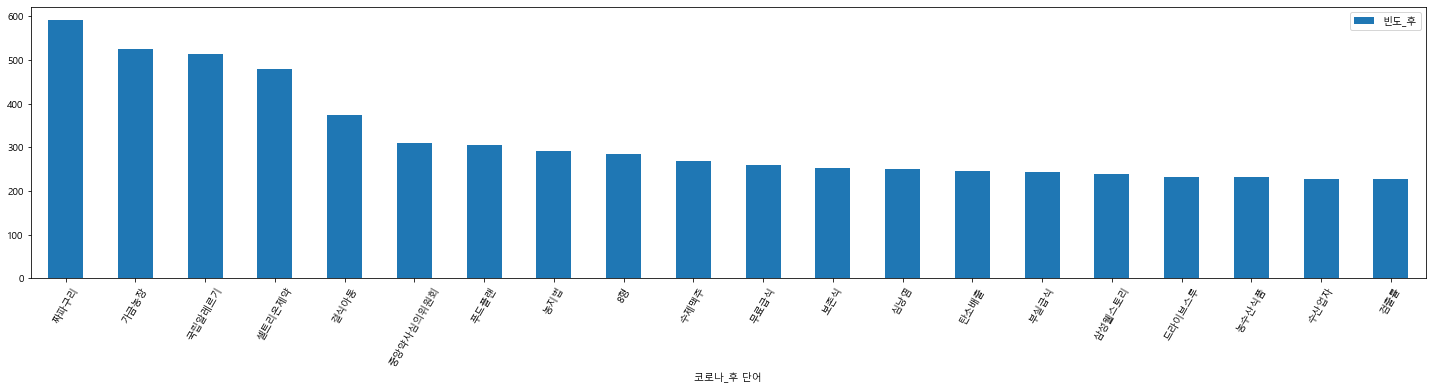

In [15]:
len(set(data['코로나_후 단어'].unique()) - set(data['코로나_전 단어'].unique()))
cor01_list = set(data['코로나_후 단어'].unique()) - set(data['코로나_전 단어'].unique())
data[data['코로나_후 단어'].isin(cor01_list)][['코로나_후 단어', '빈도_후']].set_index('코로나_후 단어')[0:20].plot(kind='bar', rot='60', figsize=(25,5)); plt.show()
data[data['코로나_후 단어'].isin(cor01_list)][['코로나_후 단어', '빈도_후']].set_index('코로나_후 단어').to_excel('../data/코로나발생 후 새롭게 출현단어.xlsx')

## Wordcloud 코로나 전 단어에서 직접 단어 제거

<Figure size 432x432 with 0 Axes>

([], [])

([], [])

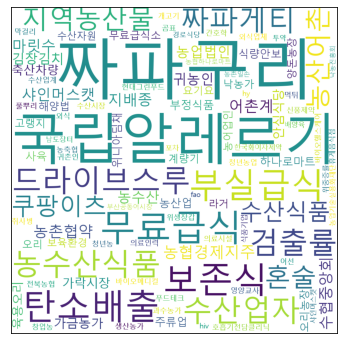

In [16]:
from wordcloud import WordCloud
data = pd.read_excel('../data/코로나발생 후 새롭게 출현단어.xlsx').set_index('코로나_후 단어')
word_freq = data['빈도_후'].to_dict()


stop_words_clouds = ['결식아동', '셀트리온제약', '삼성웰스토리','8형', '가금농장', '중앙약사심의위원회', '수제맥주',
                    '농지법', '심낭염', 'cj프레시웨이', '푸드플랜'
                    ]
for key in stop_words_clouds:
    del word_freq[key]
    
wc = WordCloud(font_path=r'c:\windows\fonts\malgun.ttf',
               stopwords = stop_words,
               background_color="white",
               width=1000,height=1000, 
               max_words=100,
               relative_scaling=0.7,
               normalize_plurals=False).generate_from_frequencies(word_freq)
plt.figure(figsize=(6,6))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.show()

<Figure size 432x432 with 0 Axes>

([], [])

([], [])

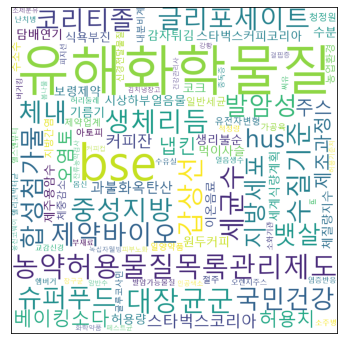

In [17]:
data = pd.read_excel('../data/코로나발생후 사라진 출현단어.xlsx').set_index('코로나_전 단어')
word_freq = data['빈도_전'].to_dict()


stop_words_clouds = ['epa', '세계무역기구', '호박즙', '금강농산', 'wfp', '혈압약', '고혈압약',
                     '위장약', '수입식품', '쇠고기'
                    ]
for key in stop_words_clouds:
    del word_freq[key]
    
wc = WordCloud(font_path=r'c:\windows\fonts\malgun.ttf',
               stopwords = stop_words,
               background_color="white",
               width=1000,height=1000, 
               max_words=100,
               relative_scaling=0.7,
               normalize_plurals=False).generate_from_frequencies(word_freq)
plt.figure(figsize=(6,6))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.show()

## 3. 코로나 전후에도 동일한 단어의 증감율

In [18]:
data = result_df.fillna(0)
data.columns = ['코로나_전 단어', '빈도_전', '코로나_후 단어', '빈도_후']

len(set(data['코로나_후 단어'].unique()) & set(data['코로나_전 단어'].unique()))

data_01 = data[['코로나_전 단어', '빈도_전']]
data_02 = data[['코로나_후 단어', '빈도_후']]

data1 = data_01.merge(data_02, left_on ='코로나_전 단어', right_on ='코로나_후 단어').drop('코로나_후 단어', axis=1)
data1['증감(%)'] = (data1['빈도_후'] - data1['빈도_전'])/data1['빈도_전']*100
data1 = data1.sort_values('증감(%)', ascending=False)
data1.to_excel('../data/코로나발생 전후 출현단어.xlsx')
data1.columns = ['출현단어', '코로나_전_빈도', '코로나_후_빈도', '증감(%)']
data1

505

,출현단어,코로나_전_빈도,코로나_후_빈도,증감(%)
477,주류,18.630008,576.366952,2993.755764
411,항바이러스,27.182635,794.221209,2821.796271
428,수산업,24.994572,671.785079,2587.723841
441,밀키트,23.667623,609.385555,2474.764475
62,소상공인,238.324477,5507.711056,2211.013592
...,...,...,...,...
36,불량식품,413.146765,254.118998,-38.491834
85,식품첨가물,169.705830,101.314509,-40.299924
65,패스트푸드점,231.484445,135.339837,-41.533939
56,gmo,256.222615,127.262192,-50.331398


In [19]:
sw = ['수산업', '농림','농축수산물', '식품의약국', '축산', '푸드', '한국농수산식품유통공사', '농특산물','농장', '농축산', '한국농어촌공사',
     '농번기', '농어촌공사', '유럽의약품청', '양돈농가', '축산농가', '수확기', '농촌', '삼양식품', '식약청', '푸드', '농민', '반찬',
     '오징어', '어린이급식관리지원센터', '고추'] # 코로나전 출현빈도는 없음 '0'
d1 = data1[~data1['출현단어'].isin (sw)].head(20).round(2)
d1.index = np.arange(20)
d1
', '.join(list(d1['출현단어']))

d1 = data1[~data1['출현단어'].isin (sw)].tail(20).round(2)
d1 = d1.sort_values('증감(%)', ascending=True)
d1.index = np.arange(20)
d1
', '.join(list(d1['출현단어']))

,출현단어,코로나_전_빈도,코로나_후_빈도,증감(%)
0,주류,18.63,576.37,2993.76
1,항바이러스,27.18,794.22,2821.80
2,밀키트,23.67,609.39,2474.76
3,소상공인,238.32,5507.71,2211.01
4,바이러스,40.43,928.33,2196.15
5,급식비,22.91,509.37,2123.02
6,귀농귀촌,17.41,316.28,1716.72
7,급식,79.92,1363.68,1606.37
8,급식실,32.72,520.25,1490.04
9,조류인플루엔자,49.83,788.01,1481.33


'주류, 항바이러스, 밀키트, 소상공인, 바이러스, 급식비, 귀농귀촌, 급식, 급식실, 조류인플루엔자, 집밥, 대체육, 스마트팜, 일반음식점, 온라인, 쌀값, 구내식당, 술집, 로컬푸드, 농축산물'

,출현단어,코로나_전_빈도,코로나_후_빈도,증감(%)
0,발암물질,2155.11,872.14,-59.53
1,gmo,256.22,127.26,-50.33
2,패스트푸드점,231.48,135.34,-41.53
3,식품첨가물,169.71,101.31,-40.30
4,불량식품,413.15,254.12,-38.49
5,호르몬,521.30,337.29,-35.30
6,중금속,2793.69,1863.14,-33.31
7,성장호르몬,168.19,119.60,-28.89
8,수질검사,260.15,206.05,-20.80
9,여성호르몬,235.32,187.75,-20.21


'발암물질, gmo, 패스트푸드점, 식품첨가물, 불량식품, 호르몬, 중금속, 성장호르몬, 수질검사, 여성호르몬, 첨가물, 보존제, 남성호르몬, 환경호르몬, 유해물질, 커피, 멜라토닌, 다이어트, 구호품, 에스트로겐'

In [20]:
data1 = data1[~data1['출현단어'].isin (sw)]
(', ').join(list(data1.sort_values('코로나_후_빈도', ascending=False).head(20)['출현단어']))

'온라인, 농산물, 안전성, 소상공인, 수산물, 오염수, 친환경, 축산물, 단백질, 음식점, 농업인, 면역력, 건강, 건강기능식품, 곰팡이, 미생물, 중금속, 건강관리, 식중독, 농식품'

# <font color='brwon'> 제3절 코로나이후 LDA 분석

## 불용어 정리

In [21]:
from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{2,}") # 정규포현식으로 토크나이저를 정의
food_stops = set(stop_words) # 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text) 
    # stopwords 제외
    words = [word for word in tokens if (word not in food_stops) and len(word) >= 2] # 2글자 이상만
    return words

# <font color='blue'> 코로나 후 데이터만 대상

In [22]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from gensim.corpora.dictionary import Dictionary

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
base_date = '2020-01-20'

df['코로나전후'] = 1
df.loc[df['일자'] <= base_date, '코로나전후'] = 0
print('코로나 전 최대 일자는')
df[df['코로나전후'] == 0]['일자'].max()

코로나 전 최대 일자는


Timestamp('2020-01-20 00:00:00')

In [25]:
df['코로나전후'].value_counts()
tf = df[df['코로나전후'] == 1]
tf.shape

1    474591
0     95674
Name: 코로나전후, dtype: int64

(474591, 9)

In [26]:
texts = [tokenizer(news) for news in tf['특성추출(가중치순 상위 50개)']]

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]

# Create Corpus: Term Document Frequency 
# corpus = [id2word.doc2bow(text) for text in data_words if text not in stop_words]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 454061
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 474591


### 토픽 7개로 LDA
- 하이퍼파라미터 2개 부터 22개 LDA수행 후 토픽 7개 결정

- topic : 당신이 가설로 잡은 토픽의 갯수는?
- chunksize : 얼마나 많은 문서가 훈련 알고리즘에 사용되는가?
- 만약에 빠른 학습이 중요하시다면, 청크사이즈를 키워서 돌려봅시다!
- Hoffman의 논문에 의하면 Chunksize는 모델 품질에 영향을 미치지만 차이그 그렇게 크진 않다고 합니다!
- passes : 패스는 모델 학습시 전체 코퍼스에서 모델을 학습시키는 빈도를 제어한다고 합니다. epochs 와 같은 용어 같다! model를 학습시키는 횟수를 말하는것 같아요! model sampling?
- iteration : 각각 문서에 대해서 루프를 얼마나 돌리는지를 제어한다고 합니다.
- pass & iteration 은 최대한 많은게 좋다!
- eval_every = 1 in LdaModel
- alpha, eta = auto, 디리클레 분포의 감마함수에 대한 파라미터입니다!

In [27]:
from gensim.models import LdaModel
import pyLDAvis.gensim
from tqdm import tqdm
from datetime import date

for num_topics in  tqdm(np.arange(7,8)):
    passes = 5
    %time model = LdaModel(corpus=corpus, id2word=dictionary,\
                           passes=passes, num_topics=num_topics, \
                           random_state=7)

    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

    pyLDAvis.save_html(vis, '../img/코로나후_' + str(num_topics) + '_topics_' + str(date.today()) + '---' + '.html')

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Wall time: 2min 11s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:30<00:00, 150.81s/it]


## Topic 벡터와 해당 단어 확인

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
import warnings
warnings.filterwarnings('ignore')

topics = model.print_topics() # (num_words=10)
for topic in topics:
    print(topic)

(0, '0.252*"축산물" + 0.051*"호르몬" + 0.051*"원산지" + 0.040*"환경호르몬" + 0.030*"추출물" + 0.019*"식감" + 0.018*"축산농가" + 0.016*"bpa" + 0.015*"농식품" + 0.014*"간편식"')
(1, '0.114*"농산물" + 0.103*"단백질" + 0.059*"미생물" + 0.042*"식재료" + 0.033*"건강" + 0.029*"유산균" + 0.023*"농업인" + 0.018*"비건" + 0.017*"매일유업" + 0.017*"프로바이오틱스"')
(2, '0.147*"오염수" + 0.089*"안전성" + 0.060*"유통기한" + 0.052*"음식물" + 0.043*"영양소" + 0.030*"불량식품" + 0.026*"원재료" + 0.025*"건강관리" + 0.022*"위생법" + 0.021*"지하수"')
(3, '0.376*"온라인" + 0.118*"중금속" + 0.077*"소상공인" + 0.035*"정수기" + 0.033*"유해물질" + 0.030*"화합물" + 0.016*"호르몬제" + 0.012*"가정간편식" + 0.010*"신경세포" + 0.010*"불량식품"')
(4, '0.209*"친환경" + 0.049*"대장균" + 0.045*"식중독" + 0.038*"멜라토닌" + 0.025*"섭취량" + 0.024*"위생" + 0.023*"식중독균" + 0.022*"농가" + 0.021*"식료품" + 0.018*"밥상"')
(5, '0.092*"수산물" + 0.078*"면역력" + 0.063*"음식점" + 0.054*"돼지고기" + 0.046*"첨가물" + 0.032*"식습관" + 0.027*"이물질" + 0.024*"가공식품" + 0.021*"화학물질" + 0.020*"맥도날드"')
(6, '0.041*"냉장고" + 0.037*"에스트로겐" + 0.036*"생산자" + 0.031*"소고기" + 0.030*"건강기능식품" + 0.029*"농축산물" + 0.027*"아이스크림" + 0

In [30]:
topics = model.print_topics(num_words=300) # (num_words=10)
for topic in topics:
    print(topic)

(0, '0.252*"축산물" + 0.051*"호르몬" + 0.051*"원산지" + 0.040*"환경호르몬" + 0.030*"추출물" + 0.019*"식감" + 0.018*"축산농가" + 0.016*"bpa" + 0.015*"농식품" + 0.014*"간편식" + 0.014*"음식" + 0.013*"주류" + 0.012*"음료수" + 0.011*"양식장" + 0.011*"테스토스테론" + 0.011*"커피" + 0.010*"배달음식" + 0.009*"탄산음료" + 0.009*"롯데칠성음료" + 0.009*"축산물품질평가원" + 0.008*"김밥" + 0.008*"해조류" + 0.008*"해수부" + 0.007*"패스트푸드점" + 0.007*"투썸플레이스" + 0.007*"해산물" + 0.007*"생수병" + 0.007*"무항생제" + 0.006*"해양수산부" + 0.006*"고춧가루" + 0.006*"한미약품" + 0.005*"다이어트" + 0.005*"농특산물" + 0.005*"농축산" + 0.005*"생리불순" + 0.005*"식사" + 0.005*"농수축산물" + 0.004*"농관원" + 0.004*"축종" + 0.004*"갑상선" + 0.004*"신체" + 0.003*"건강식" + 0.003*"담즙" + 0.003*"고급육" + 0.003*"닭가슴살" + 0.003*"무상급식" + 0.003*"요기요" + 0.003*"어패류" + 0.003*"음식들" + 0.003*"조개류" + 0.003*"구균" + 0.003*"주류업" + 0.003*"원산지표시" + 0.003*"라면" + 0.003*"와인" + 0.003*"쿠팡이츠" + 0.003*"한국식품커뮤니케이션포럼" + 0.003*"개고기" + 0.003*"혼합물" + 0.003*"표고버섯" + 0.003*"축산물위생관리법" + 0.003*"수자원" + 0.003*"신부전증" + 0.003*"생수" + 0.002*"보건법" + 0.002*"남도장터" + 0.002*"축산물이력제" + 0.002*"테아닌" +

In [31]:
for i, topic_list in enumerate(model[corpus]):
    if i==5:
        break
    print(i,'번째 문서의 topic 비율은',topic_list)

0 번째 문서의 topic 비율은 [(0, 0.02857192), (1, 0.22857408), (2, 0.02857192), (3, 0.02857192), (4, 0.02857192), (5, 0.02857192), (6, 0.62856627)]
1 번째 문서의 topic 비율은 [(0, 0.46042287), (1, 0.4601889), (2, 0.015877651), (3, 0.015877651), (4, 0.015877651), (5, 0.015877651), (6, 0.015877651)]
2 번째 문서의 topic 비율은 [(0, 0.023822881), (1, 0.35735077), (2, 0.19009894), (3, 0.023822883), (4, 0.19051065), (5, 0.023822881), (6, 0.190571)]
3 번째 문서의 topic 비율은 [(0, 0.028689321), (1, 0.42688128), (2, 0.22881344), (3, 0.02868928), (4, 0.028689291), (5, 0.22954808), (6, 0.028689273)]
4 번째 문서의 topic 비율은 [(0, 0.028586656), (1, 0.42833948), (2, 0.028586656), (3, 0.028586656), (4, 0.22865818), (5, 0.22865568), (6, 0.028586656)]


### 문서집단(corpus)를 토픽별로 비중을 확인

In [32]:
doc_topics =[]
for topic_list in model[corpus]:
    ulist =[]
    for j in range(len(topic_list)):
        ulist.append(topic_list[j][1]) # topic 이 5개인 경우도 있음 모두 9개는 아님
    doc_topics.append(ulist)

In [34]:
pd.DataFrame(doc_topics).head()

,0,1,2,3,4,5,6
0,0.028572,0.228574,0.028572,0.028572,0.028572,0.028572,0.628566
1,0.460423,0.460189,0.015878,0.015878,0.015878,0.015878,0.015878
2,0.023823,0.357351,0.190099,0.023823,0.190511,0.023823,0.190571
3,0.028689,0.426881,0.228813,0.028689,0.028689,0.229548,0.028689
4,0.028587,0.428339,0.028587,0.028587,0.228658,0.228656,0.028587


## 연관단어를 구하기 위해 단어장 만들기

In [35]:
from gensim.models import Word2Vec
corpus = [tokenizer(news) for news in tf['특성추출(가중치순 상위 50개)']]
wv_model = Word2Vec(sentences=corpus, size=100, window=5, min_count=50, workers=4, sg=0)

word_vectors = wv_model.wv
#word_vectors
vocabs = word_vectors.vocab.keys()
#vocabs
word_vectors_list = [word_vectors[v] for v in vocabs]
len(word_vectors_list)

1544

In [36]:
words = []
for i in range(0, model.num_topics):
    #print('Topic', i)
    for token, score in model.show_topic(i):
        #(token, score)
        words.append(token)
    #print('*'*100)

In [37]:
words[0:10]

['축산물', '호르몬', '원산지', '환경호르몬', '추출물', '식감', '축산농가', 'bpa', '농식품', '간편식']

In [38]:
my_dict = {'Topic_' + str(i): [token for token, score in model.show_topic(i, topn=10)] for i in range(0, model.num_topics)}
my_dict.keys()

dict_keys(['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6'])

In [39]:
cos ={}
co = []
for word in words:
    co.append([word, wv_model.wv.most_similar(word)])
    cos.update(wv_model.wv.most_similar(word))

In [40]:
data = pd.DataFrame(co, columns=['단어', '연관단어'])
data['topic'] = 0
for i in range(8):
    #i*10, ((i+1)*9+i)
    data.loc[i*10:((i+1)*9+i)+1, 'topic'] = i+1

In [41]:
list =[]    
for row in data.iterrows():
    list.append([row[1][1][i][0] for i in range(10)])
cos = data.merge(pd.DataFrame(list), left_index=True, right_index=True).drop('연관단어', axis=1)
cos.columns = ['단어', 'Topic', '연관어 1', '연관어 2', '연관어 3', '연관어 4', '연관어 5',
              '연관어 6', '연관어 7', '연관어 8', '연관어 9', '연관어 10']

In [43]:
len(corpus)

474591

In [42]:
for i in range(1, 8):
    print('Topic_ ' + str(i))
    cos[cos['Topic'] == i].set_index('단어').drop('Topic', axis=1)

Topic_ 1


,연관어 1,연관어 2,연관어 3,연관어 4,연관어 5,연관어 6,연관어 7,연관어 8,연관어 9,연관어 10
단어,,,,,,,,,,
축산물,농축산물,한우고기,생산자,돼지고기,한돈,과일류,전국한우협회,나물류,서울시농수산식품공사,농산물품질관리원
호르몬,흡수,체내,소화,근육,수분,치매,알레르기,신체,아토피,약물
원산지,원산지표시,절임배추,수입산,새우젓,농산물품질관리원,농관원,성수식품,국립수산물품질관리원,국립농산물품질관리원,고춧가루
환경호르몬,화학물질,발암물질,유해화학물질,유해물질,유독물질,급성중독,화합물,화학약품,얼음정수기,살균수
추출물,피로회복,오메가3,루테인,알로에,밀크씨슬,항노화,발효홍삼,홍삼정,강황,일반식품
식감,단맛,매운맛,향신료,신맛,밀가루,체리,들기름,조미료,청양고추,견과류
축산농가,축산악취,축산농장,축산환경,가축질병,사육환경,축종,농장주,축산인,사료비,브루셀라병
bpa,해양생태계,수산자원,어촌계,양식업,ipa,어획물,해양수산,어선,어촌뉴딜,어선들
농식품,전통식품,신선농산물,농업회사법인,샤인머스켓,농업회사법,농식품유통과장,농수특산물,지역특산품,농특산품,직거래장터


Topic_ 2


,연관어 1,연관어 2,연관어 3,연관어 4,연관어 5,연관어 6,연관어 7,연관어 8,연관어 9,연관어 10
단어,,,,,,,,,,
농산물,생산농가,과채류,경기도농수산진흥원,하나로마트,로컬푸드직매장,지역농산물,유기가공식품,엽채류,농협경제지주,직거래장터
단백질,지방산,필수아미노산,동맥경화,근감소증,한국식품커뮤니케이션포럼,통곡물,섬유질,중성지방,콩류,포화지방
미생물,바실러스,병원균,유용미생물,유해균,배양기,효모균,병균,균종,진균,곰팡이균
식재료,영양사,팽이버섯,급식센터,급식비,식단표,영양교사,급식지원센터,기본급식비,무상급식비,채소류
건강,홍삼,비타민,신체,다이어트,섭취,뿌리,칼슘,가지,버섯,간식
유산균,유익균,프로바이오,바이오일레븐,생유산균,야쿠르트,락토바실러스,프락토올리고당,신바이오틱스,hy,담즙산
농업인,영농조합법인,농기계,저온저장고,토양개량제,도시농업,수확물,영세농,재배농가,농업경영체,식량작물
비건,대체육,채식주의자,대체식품,푸드테크,채식주,채식주의,식물성,배양육,콩기름,청정원
매일유업,셀렉스,상하목장,요플레,영양식,롯데제과,컵커피,동물성,식물성,롯데푸드,빙그레


Topic_ 3


,연관어 1,연관어 2,연관어 3,연관어 4,연관어 5,연관어 6,연관어 7,연관어 8,연관어 9,연관어 10
단어,,,,,,,,,,
오염수,조피볼락,부산공동어시장,어획물,해양생태계,공동어시장,어촌계,수산자원,마을어장,수협중앙회,수산자원연구소
안전성,품질검사,진균,미생물학,중앙약사,곰팡이균,허용치,중앙약사심의위원회,식약처장,항곰팡이,오염물
유통기한,포장육,위생관리,식품위생법,불량식품,식품제조,냉동제품,빵류,위생법,떡류,수입식품
음식물,음식물쓰레기,위장염,살모넬,장출혈,장출혈성대장균,살모넬라균,냉장보관,김치냉장고,위니아딤채,노로바이러스
영양소,섭취량,식이섬유,견과류,한국식품커뮤니케이션포럼,콩류,섬유질,통곡물,건강식,영양학,브로콜리
불량식품,위생모,부정식품,식품제조,배달음식점,위생상태,냉동제품,분식점,조리식품,식품접객업소,분식집
원재료,식품업체,한성식품,해썹,떡류,향신료,과자류,밀가루,음료류,김치공장,빵류
건강관리,건강상태,엽산제,철분제,신체활동,소화불량,체질량지수,여성호르몬,모유수유,영양섭취,체중감량
위생법,식품위생법,식품제조,불량식품,위생모,부정식품,위생상태,냉동제품,식품접객업소,유통기한,위생관리


Topic_ 4


,연관어 1,연관어 2,연관어 3,연관어 4,연관어 5,연관어 6,연관어 7,연관어 8,연관어 9,연관어 10
단어,,,,,,,,,,
온라인,식품수출이사,국가식품클러스터,오아시스마켓,한국식품,식품명,쌀가공식품,즉석조리식품,소스류,프레시몰,과자류
중금속,유해물질,잔류농약,화합물,발암물질,허용치,화학약품,화학물질,오염물,유독물질,오염물질
소상공인,음식점업,국산김치,외식업체,외식업소,요식업,외식산업,외식비,새우젓,농림수산품,원산지표시
정수기,코크,얼음정수기,살균수,위생성,일반세균,위니아딤채,총대장균군,제빙기,총대장균,유해화학물질
유해물질,환경호르몬,화학물질,발암물질,화합물,중금속,유독물질,유해화학물질,허용치,급성중독,화학약품
화합물,화학물질,화학약품,발암물질,환경호르몬,유독물질,항곰팡이,급성중독,오염물,유해물질,ph
호르몬제,성장호르몬,결핍증,테스토스테론,시상하부,남성호르몬,근력운동,체중감소,췌장염,식도염,신경전달물질
가정간편식,밀키트,간편식,소스류,통조림,가정식,프레시,참치캔,쌀가공식품,더반찬,떡갈비
신경세포,결핍증,췌장염,아밀로이드,신경전달물질,지방간염,단백뇨,식도염,콩팥병,동화약품,체중감소


Topic_ 5


,연관어 1,연관어 2,연관어 3,연관어 4,연관어 5,연관어 6,연관어 7,연관어 8,연관어 9,연관어 10
단어,,,,,,,,,,
친환경,탄소배출,무농약,다품종,유기농업,친환경농업,유기농법,밥맛,친환경농법,사탕수수,나주배
대장균,살모넬,살모넬라균,세균수,식중독균,대장균군,리스테리아균,장출혈성대장균,비브리오균,유해세균,햄버거병
식중독,위생관리,보존식,살모넬라균,집단급식소,장출혈성대장균,조리과정,리스테리아균,식중독균,살모넬,세균수
멜라토닌,여성호르몬,체중감량,에스트로겐,소화불량,체질량지수,허리둘레,담즙,식욕부진,식도염,약물치료
섭취량,영양소,한국식품커뮤니케이션포럼,콩류,통곡물,견과류,뱃살,식이요법,체중감량,영양학,식이섬유
위생,위생적,식용,냉장,식육,점심,식당,위생과,배식,위생상태,식탁
식중독균,리스테리아균,살모넬라균,대장균,살모넬,위생관리,보존식,세균수,장출혈성대장균,햄버거병,팽이버섯
농가,고추,딸기,농부,감자,마늘,양파,토마토,복숭아,농민,농촌일손
식료품,떡국떡,집밥,장조림,롯데슈퍼,생활필수품,상차림,총각김치,즉석식품,외식물가,반찬류


Topic_ 6


,연관어 1,연관어 2,연관어 3,연관어 4,연관어 5,연관어 6,연관어 7,연관어 8,연관어 9,연관어 10
단어,,,,,,,,,,
수산물,민물장어,해양수산부,자연산,생협,뱀장어,한국해양수산개발원,수산대전,수협중앙회,어촌마을,마을어장
면역력,홍삼정,프로폴리스,알로에,피로회복,소화기관,영양제,항산화,발효홍삼,kgc인삼공사,배변활동
음식점,휴게음식점,일반음식점,부정식품,식품접객업소,요식업,위생모,위생과,위생등급,배달음식점,식품위생업소
돼지고기,닭고기,소고기,수입육,나물류,신선식품지수,전국한우협회,오리고기,흑돼지,목심,한돈
첨가물,단맛,신맛,농축액,이유식,청국장,향신료,밀가루,식이섬유,체리,식품들
식습관,영양학,저체중,신체활동,조제분유,영양학적,영양교육,영양관리,영양플러스사업,섭취량,영양상태
이물질,급식통,냉동실,제빙기,식품용,코크,위니아딤채,얼음정수기,가스레인지,냉장고,정수기
가공식품,소스류,천일염,과자류,손맛,김치류,떡갈비,시식회,포기김치,가정식,전통식품
화학물질,환경호르몬,발암물질,화합물,유해화학물질,유독물질,항곰팡이,살균수,유해물질,화학약품,위생성


Topic_ 7


,연관어 1,연관어 2,연관어 3,연관어 4,연관어 5,연관어 6,연관어 7,연관어 8,연관어 9,연관어 10
단어,,,,,,,,,,
냉장고,김치냉장고,냉동실,위니아딤채,냉장실,냉장보관,조리과정,밥솥,가스레인지,장출혈,제빙기
에스트로겐,여성호르몬,비타민d,멜라토닌,흡수율,비타민a,글루코사민,msm,혈류량,보충제,테아닌
생산자,풋고추,건고추,군급식,농협하나로마트,하나로마트,농림수산품,직거래장터,가락시장,농축산물,가을배추
소고기,닭고기,돼지고기,보양식,김치찌개,불고기,생닭,칼국수,외식물가,짜장면,생선회
건강기능식품,프로폴리스,건기식,홍삼정,일반식품,한국건강기능식품협회,루테인,흑마늘,밀크씨슬,농축액,멀티비타민
농축산물,하나로마트,건고추,군급식,농협하나로마트,풋고추,농협몰,농협경제지주,가을배추,가락시장,농협하나로유통
아이스크림,롯데푸드,마카롱,삼각김밥,뚜레쥬르,비빔면,배스킨라빈스,에어프라이어,버거킹,빙그레,식음료업
농축수산물,신선식품지수,서울시농수산식품공사,농림수산품,가락시장,농축수산,나물류,농수축산물,풋고추,새우젓,수산품
닭고기,오리고기,돼지고기,소고기,수입육,신선육,생닭,흑돼지,하림,통닭,목심


# 제4절 토픽별 키워드 네트워크 분석
### 각 토픽별로 코사인유사성을 구한 후 SNA 수행

### doc_topics에 nan이 있어 의미는 '0'라 fillna(0)

In [44]:
summary(pd.DataFrame(doc_topics))
np.argmax(pd.DataFrame(doc_topics).fillna(0).values, axis=1)

,데이터형태(dtypes),비 결측치 수(notnull,결측치 수(null),고유값 수(nunique)
0,float32,474591,0,57932
1,float32,474591,0,60667
2,float32,474591,0,53902
3,float32,474591,0,52753
4,float64,474585,6,54913
5,float64,474569,22,58202
6,float64,474553,38,58112


array([6, 0, 1, ..., 0, 6, 0], dtype=int64)

In [45]:
data = pd.DataFrame(doc_topics, columns= ['Topic #0', 'Topic #1', 'Topic #2', 'Topic #3', 'Topic #4', 'Topic #5', 'Topic #6']).fillna(0)

data['topic'] = np.argmax(pd.DataFrame(doc_topics).fillna(0).values, axis=1)
data
data['topic'].value_counts(normalize=True)

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,topic
0,0.028572,0.228574,0.028572,0.028572,0.028572,0.028572,0.628566,6
1,0.460423,0.460189,0.015878,0.015878,0.015878,0.015878,0.015878,0
2,0.023823,0.357351,0.190099,0.023823,0.190511,0.023823,0.190571,1
3,0.028689,0.426881,0.228813,0.028689,0.028689,0.229548,0.028689,1
4,0.028587,0.428339,0.028587,0.028587,0.228658,0.228656,0.028587,1
...,...,...,...,...,...,...,...,...
474586,0.071429,0.071429,0.071429,0.071429,0.071429,0.571428,0.071429,5
474587,0.017860,0.017859,0.358625,0.017867,0.294830,0.148881,0.144078,2
474588,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0
474589,0.035716,0.035716,0.035716,0.035716,0.285705,0.285708,0.285724,6


0    0.605387
1    0.089509
3    0.086034
5    0.061503
2    0.060760
6    0.050652
4    0.046156
Name: topic, dtype: float64

In [46]:
tf.index = np.arange(len(tf))
tf.loc[data[data['topic'] == 0].index, :].shape
tf.loc[data[data['topic'] == 1].index, :].shape

(287311, 9)

(42480, 9)

## Topic에 속한 기사 단어의 코사인 유사성을 구한다

### 유사도는 −1에서 1까지의 값을 가지며, −1은 서로 완전히 반대되는 경우, 0은 서로 독립적인 경우, 1은 서로 완전히 같은 경우를 의미한다.

In [50]:
tf.drop(['통합 분류1', '통합 분류2', '통합 분류3', '코로나전후', '키워드'], axis=1).head()

,일자,언론사,특성추출(가중치순 상위 50개),본문,topic
0,2020-03-20,중도일보,"시범판매,밀가루,농산물,밀산업,자급률,병해충,소비자,육성법,소비량,신규제품,16톤,...","한국농수산식품유통공사(aT, 사장 이병호)는 지난해 수매한 국산 밀가루 16톤을 오...",6
1,2020-03-20,중도일보,"아쿠아포닉스,고창군,고창군청,지원사업,이영성,아쿠아포닉스코리아,재배법,수경재배,환경...",전북 고창군의 한 농장이 물고기 양식장에서 나온 유기물로 작물을 재배하는 '아쿠아포...,0
2,2020-03-20,전북도민일보,"남부안농협,로컬푸드,토양개량제,직매장,농산물,고품질,무상지원,농가소득,732포,최우...",남부안농협(조합장 최우식)은 로컬푸드 고품질 농산물 생산을 위한 토양개량 지원사업...,1
3,2020-03-20,충청투데이,"면역력,백마강,부여군,관계자,부여군농업기술센터,병해충,클로로젠산,농약허용물질목록관리...",[충청투데이 김일순 기자] 부여군농업기술센터는 남면 지역에서 고품질 백마강 취나물 ...,1
4,2020-03-19,대전일보,"타작물,보령시,농업인,간척지,ha,연명부,소재지,기반정비,선별기,방제기,수확기,농기...",[보령] 보령시는 논 타작물 재배 확산을 위해 타작물 재배에 필요한 기반정비 및 생...,1


In [49]:
tf['topic'] = data['topic'] 
sf = tf[['일자', '특성추출(가중치순 상위 50개)', '본문', 'topic']].copy()
sf.shape
print('Topic_0')
sf[sf['topic'] == 0].head()
sf[sf['topic'] == 0].shape

(474591, 4)

Topic_0


,일자,특성추출(가중치순 상위 50개),본문,topic
1,2020-03-20,"아쿠아포닉스,고창군,고창군청,지원사업,이영성,아쿠아포닉스코리아,재배법,수경재배,환경...",전북 고창군의 한 농장이 물고기 양식장에서 나온 유기물로 작물을 재배하는 '아쿠아포...,0
16,2020-03-15,"코로나19,지역사회,주산농협,감염병,보령,저소득,공공시설,방역복,유창림,중부매일,방...",- \n \n［중부매일 유창림 기자］바이러스 감염병 청정지역 보령에서 세계적으로 확...,0
26,2020-03-12,"언컷,엘라코닉,고객들,광주신세계,브라렛,니치,여성들,신세계백화점,그동안,신세계,하이엔드",[아시아경제 호남취재본부 신동호 기자] 신세계백화점이 프리미엄 속옷 시장까지 넘보고...,0
29,2020-03-11,"축산업,축산법,보수교육,이수,점검반,일제점검,등록자,사천시,축산농가,관계자,농약사용...",사천시는 축산법 제28조에 따라 가축질병의 효율적 차단ㆍ방역 등 축산업의 기반강화를...,0
44,2020-03-04,"청와대,김여정,남측,대남,위원장,남북정상회담,김정은,김영철,노동당,판문점,평창,군사...","""청와대의 이러한 비론리적인 주장과 언동은 개별적인 누구를 떠나 남측 전체에 대한 ...",0


(287311, 4)

In [52]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
pd.options.display.float_format = '{:,.2f}'.format
# 단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그린다
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [54]:
def plot_2d_graph(vocabs, xs, ys):    
    plt.figure(figsize=(15 ,10))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

## 토픽별 관련단어 네트웍그래프 (2차원)

토픽_0, 출현단어는 총 186 개


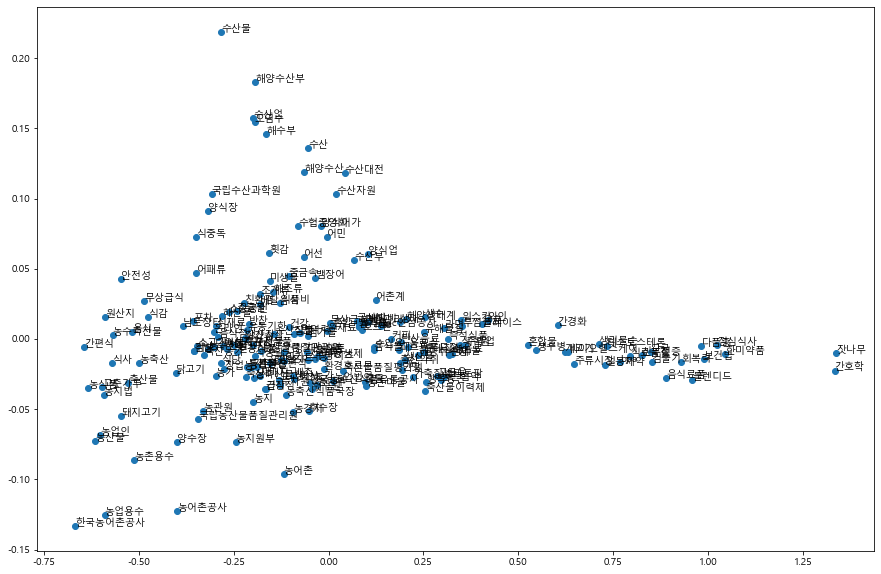

토픽_1, 출현단어는 총 382 개


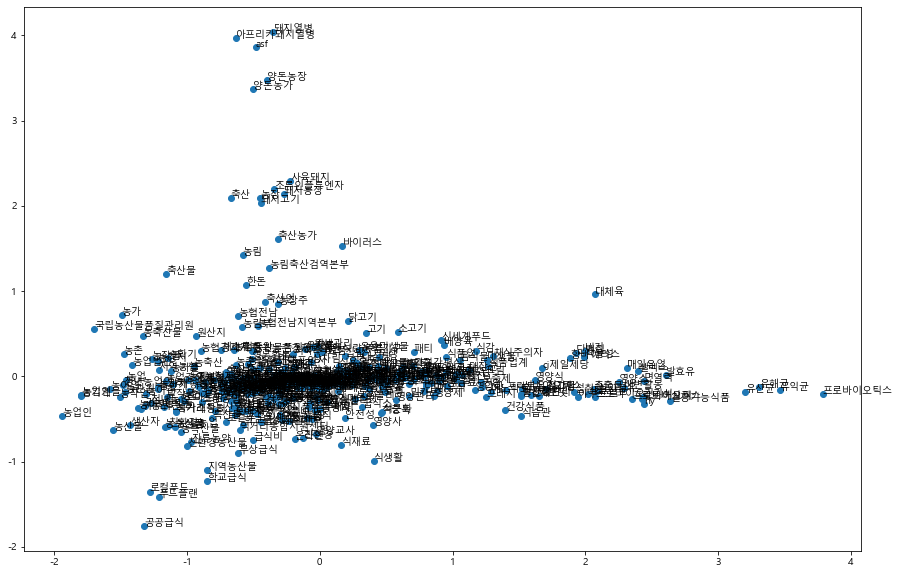

토픽_2, 출현단어는 총 148 개


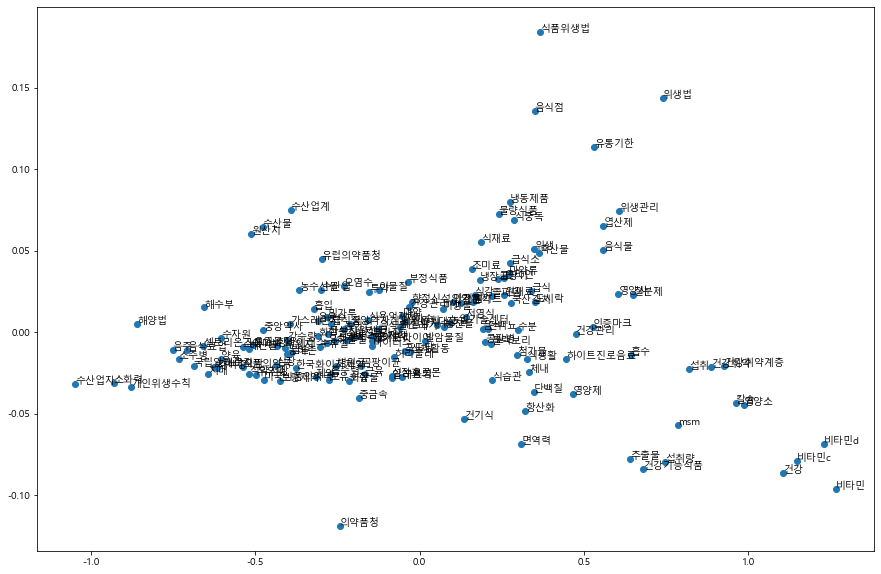

토픽_3, 출현단어는 총 130 개


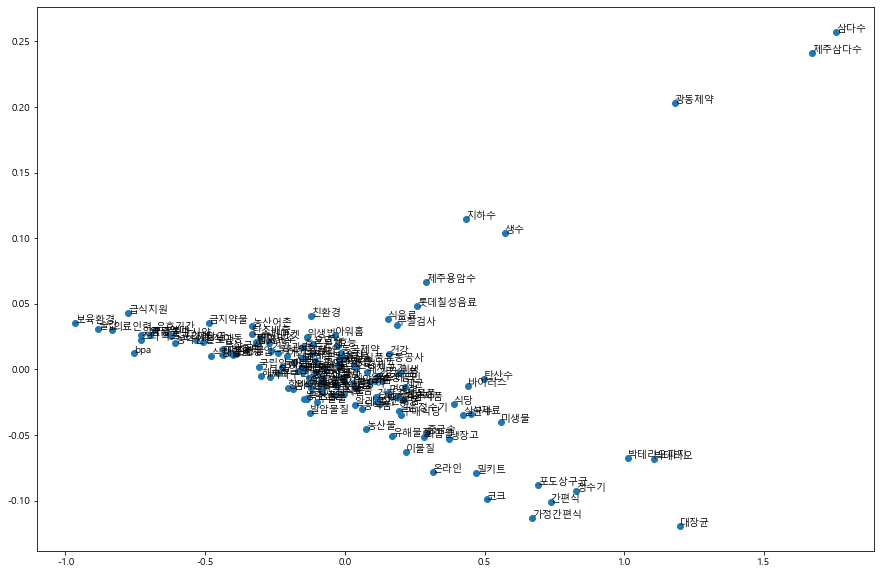

토픽_4, 출현단어는 총 198 개


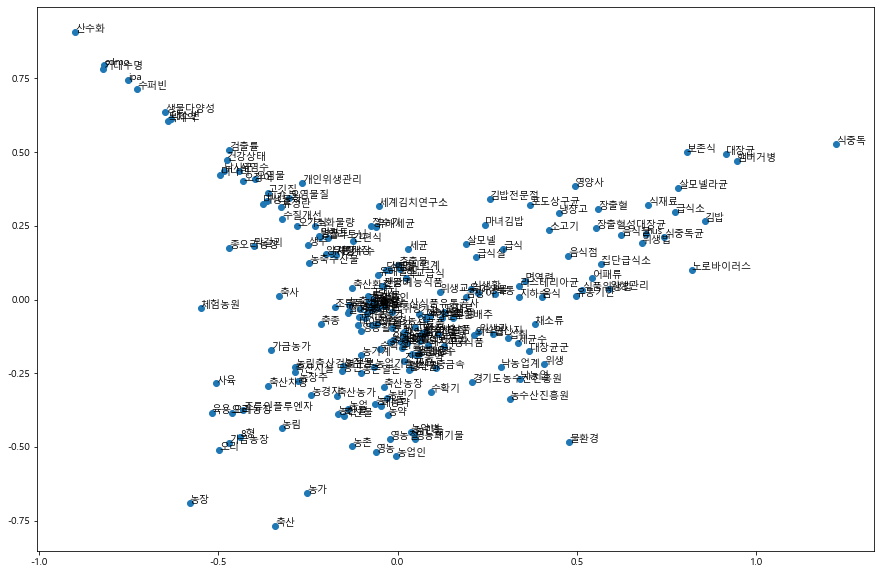

토픽_5, 출현단어는 총 235 개


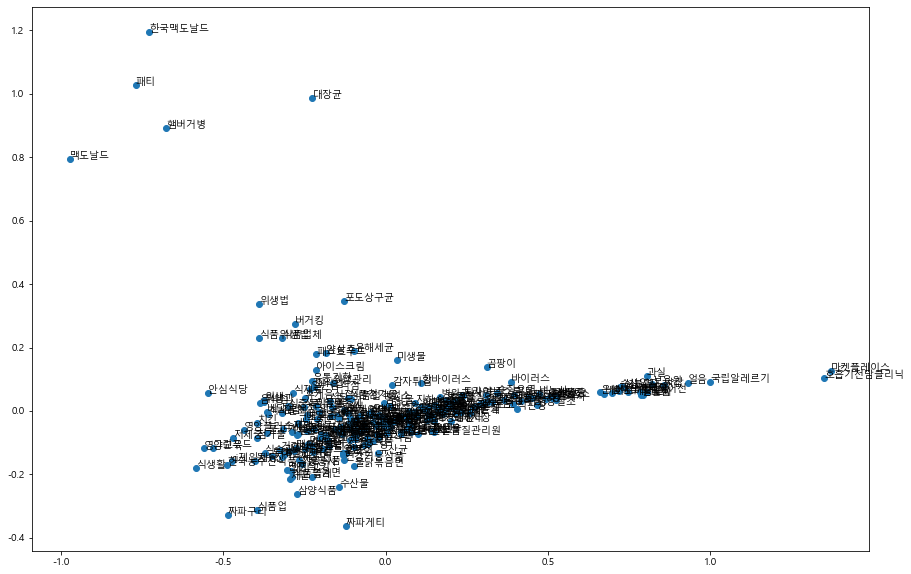

토픽_6, 출현단어는 총 239 개


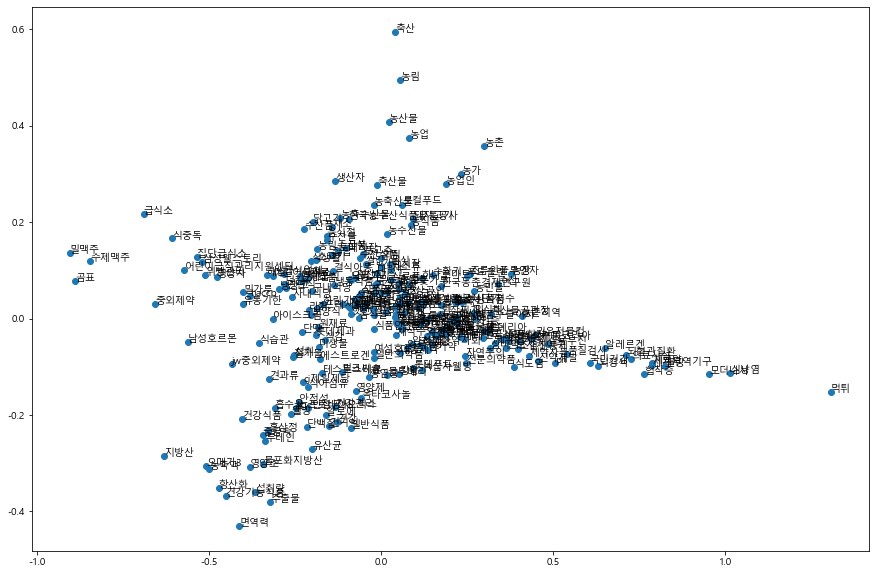

In [56]:
for i in np.arange(7):
    cos_data = sf[sf['topic'] == i]
    corpus = [tokenizer(news) for news in cos_data['특성추출(가중치순 상위 50개)']]
    
    model = Word2Vec(sentences=corpus, size=30, window=5, min_count=50, workers=4, sg=0)

    word_vectors = model.wv
    vocabs = word_vectors.vocab.keys()
    word_vectors_list = [word_vectors[v] for v in vocabs]
    
    print(f'토픽_{str(i)}, 출현단어는 총 {len(word_vectors_list)} 개')

    cosinematrix = pd.DataFrame(cosine_similarity(word_vectors_list,dense_output=False), columns=vocabs)
    cosinematrix.index = vocabs

    pca = PCA(n_components=2)
    xys = pca.fit_transform(word_vectors_list)
    xs = xys[:,0]; ys = xys[:,1]

    plot_2d_graph(vocabs, xs, ys)
    
    plt.show()

## 토픽별 관련단어 네트웍그래프 (3차원)

In [62]:
from mpl_toolkits import mplot3d
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [65]:
def plot_3d_graph(vocabs, xs, ys, zs):    
    labels =[]
    for key in vocabs:
        labels.append(key)
    
    ax3d = plt.figure(figsize=(15,20)).gca(projection='3d')
    arrayx = xs; arrayy = ys; arrayz = zs
    arrayx = arrayx.flatten(); arrayy = arrayy.flatten(); arrayz = arrayz.flatten()

    ax3d.scatter(arrayx, arrayy, arrayz, color='b')
    ax3d.view_init(10, 250) # 그림의 각도 250도    

    # 3차원 좌표에 label 부여하기
    [ax3d.text(x, y, z, label, color='k', fontsize=10) for x, y, z, label in zip(arrayx, arrayy, arrayz, labels)]

In [58]:
cos_data = sf[sf['topic'] == 1]
corpus = [tokenizer(news) for news in cos_data['특성추출(가중치순 상위 50개)']]

model = Word2Vec(sentences=corpus, size=30, window=5, min_count=50, workers=4, sg=0)

word_vectors = model.wv
vocabs = word_vectors.vocab.keys()

In [66]:
pca = PCA(n_components=3)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]; ys = xys[:,1]; zs = xys[:,2] 

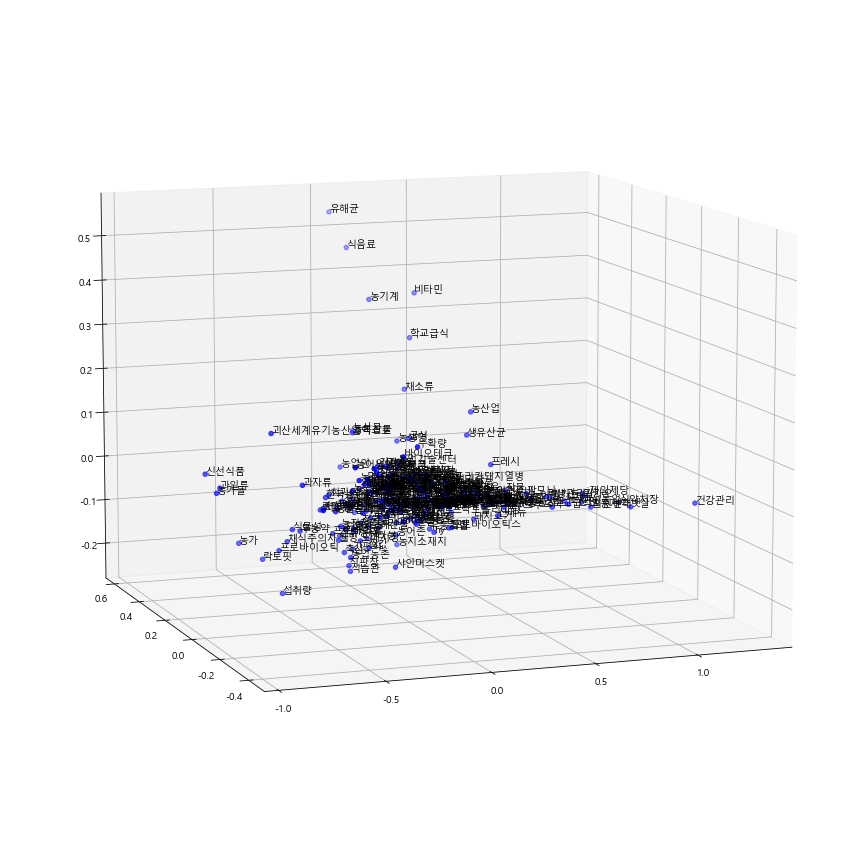

In [67]:
plot_3d_graph(vocabs, xs, ys, zs)

## t-SNE 토픽을 정하고 그리기

In [68]:
def plot_2d_tsne_graph(vocabs, xs, ys):    
    plt.figure(figsize=(20, 15))
    plt.scatter(xs, ys, color = 'blue')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

In [76]:
cos_data = sf[sf['topic'] == 6]
corpus = [tokenizer(news) for news in cos_data['특성추출(가중치순 상위 50개)']]

model = Word2Vec(sentences=corpus, size=30, window=5, min_count=50, workers=4, sg=0)

word_vectors = model.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]
len(word_vectors_list)

239

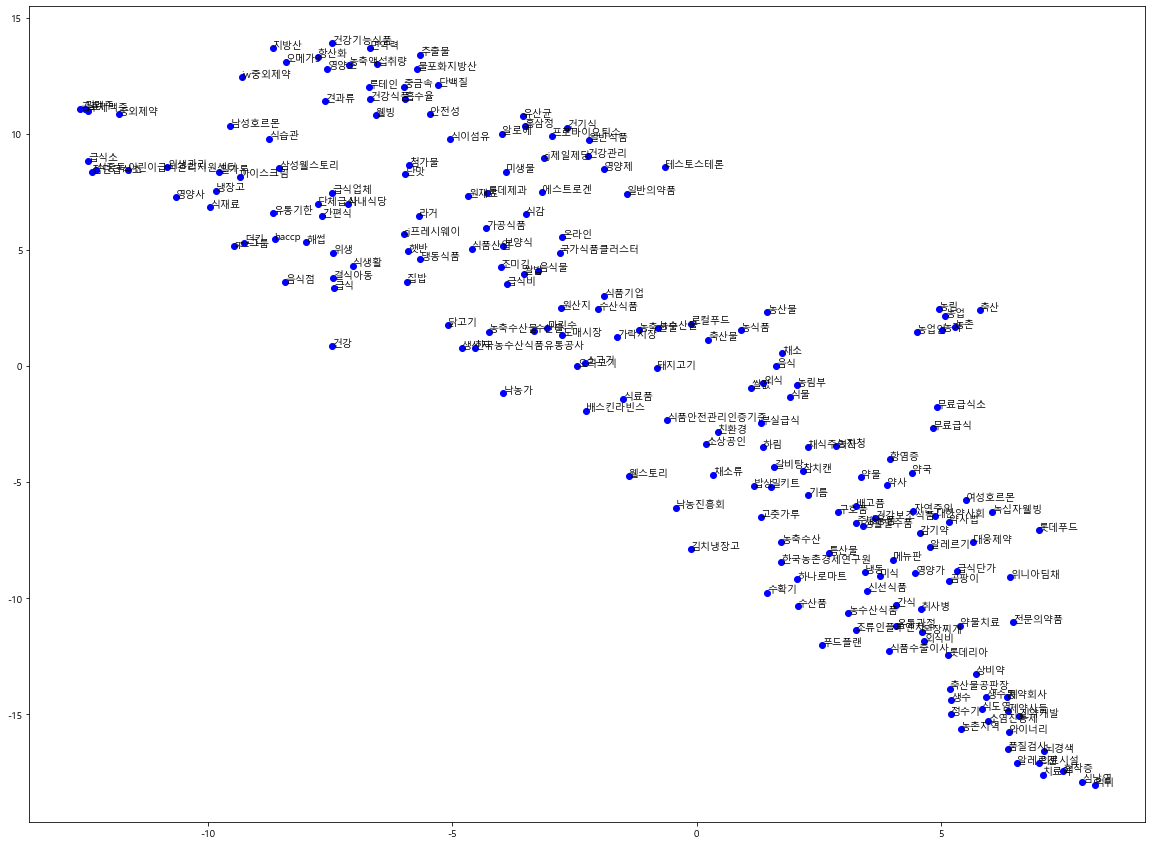

In [75]:
from sklearn.manifold import TSNE
# 2차원 t-SNE 임베딩
tsne_np = TSNE(n_components = 2).fit_transform(word_vectors_list)

plot_2d_tsne_graph(vocabs, tsne_np[:, 0], tsne_np[:, 1])

# 제6절 코로나이후 식품 관련 사건 탐지
## 각 Topic의 추세확인

In [58]:
doc_topics =[]
for topic_list in tqdm(model[corpus]):
    ulist =[]
    for j in range(len(topic_list)):
        ulist.append(topic_list[j][1]) # topic 이 5개인 경우도 있음 모두 9개는 아님
    doc_topics.append(ulist)

100%|███████████████████████████████████████████████████████████████████████| 474591/474591 [00:38<00:00, 12276.92it/s]


In [59]:
trend_data = pd.DataFrame(doc_topics)
trend_data['start'] = tf['일자'].values
trend_data = trend_data.set_index('start')
trend_data = trend_data.resample('M').mean()
trend_data#.background_gradient(cmap='Blues')

,0,1,2,3,4,5,6
start,,,,,,,
2020-01-31,0.153336,0.146543,0.142357,0.139294,0.129976,0.144893,0.143677
2020-02-29,0.138815,0.149262,0.138841,0.147032,0.128498,0.160611,0.137006
2020-03-31,0.135007,0.154654,0.143027,0.145126,0.132824,0.150973,0.138409
2020-04-30,0.138629,0.166390,0.135565,0.144416,0.128331,0.147902,0.138837
2020-05-31,0.135183,0.164687,0.135836,0.143170,0.129517,0.150951,0.140744
2020-06-30,0.140738,0.154853,0.129276,0.140936,0.160536,0.136277,0.137418
2020-07-31,0.137893,0.164567,0.135973,0.152461,0.137729,0.135623,0.135770
2020-08-31,0.145218,0.167995,0.134272,0.141743,0.129736,0.139864,0.141172
2020-09-30,0.142171,0.161737,0.136999,0.148740,0.123400,0.139756,0.147246


Text(0.5, 1.0, '0')

Text(0.5, 1.0, '1')

Text(0.5, 1.0, '2')

Text(0.5, 1.0, '3')

Text(0.5, 1.0, '4')

Text(0.5, 1.0, '5')

Text(0.5, 1.0, '6')

Text(0.5, 1.0, '시간별 Topic 추세선')

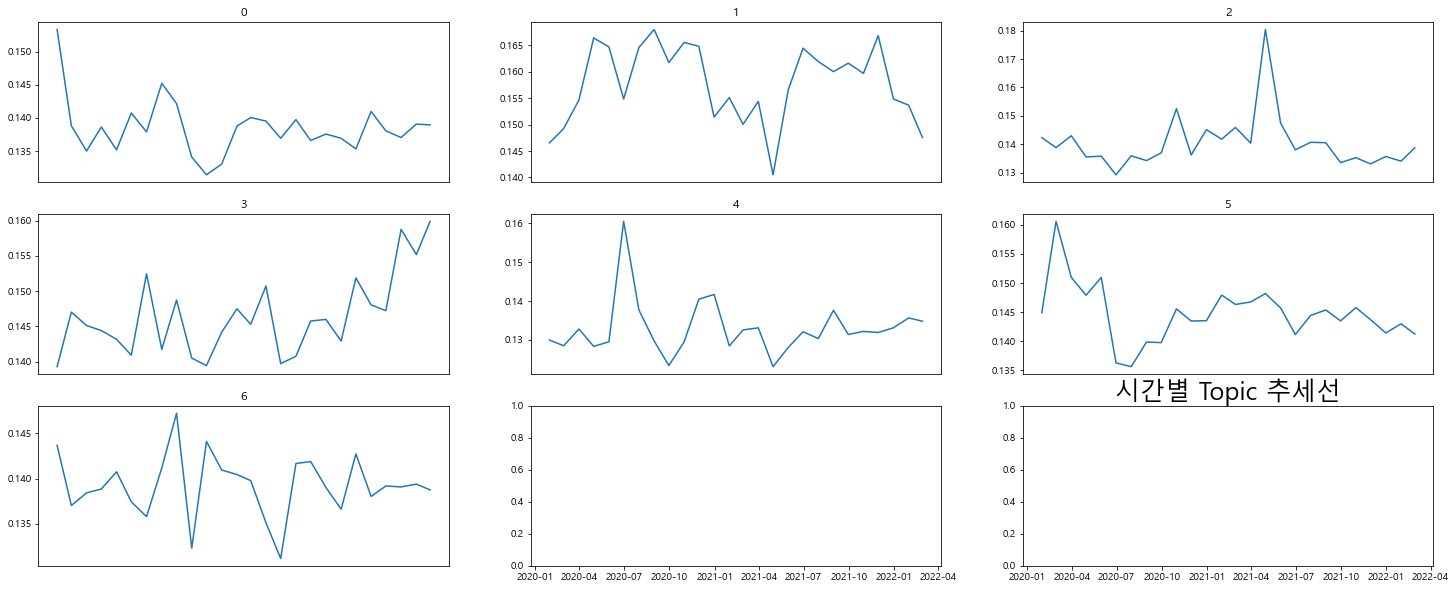

In [60]:
fig, axes = plt.subplots(3, 3, sharex='col', figsize=(25, 10)) 
for col, ax in zip(trend_data.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend_data[col])
plt.title('시간별 Topic 추세선', fontsize=25)
plt.show()

<Figure size 1440x360 with 0 Axes>

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993., 19083.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

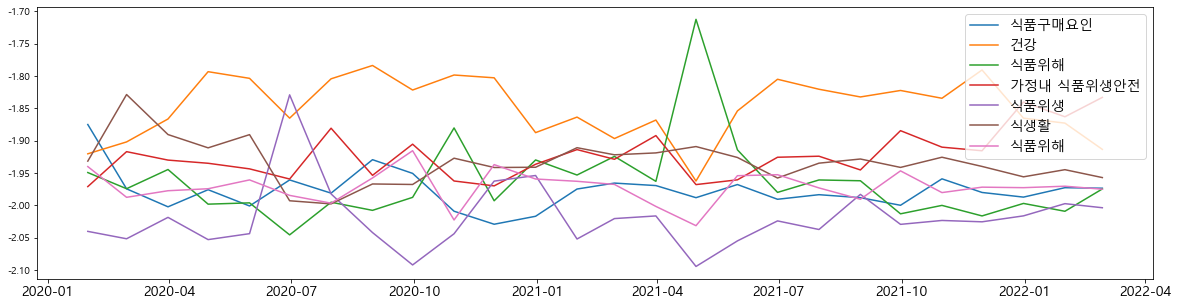

In [61]:
plt.figure(figsize=(20, 5))
plt.plot(np.log(trend_data))

#plt.legend(labels=('Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6'), loc='best')
plt.legend(labels=('식품구매요인', '건강', '식품위해', '가정내 식품위생안전', '식품위생', '식생활','식품위해')
           , fontsize= 14, loc='best')
plt.xticks(fontsize=14)

## 사건 탐지 (가우시안스무딩)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1440x576 with 0 Axes>

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993., 19083.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

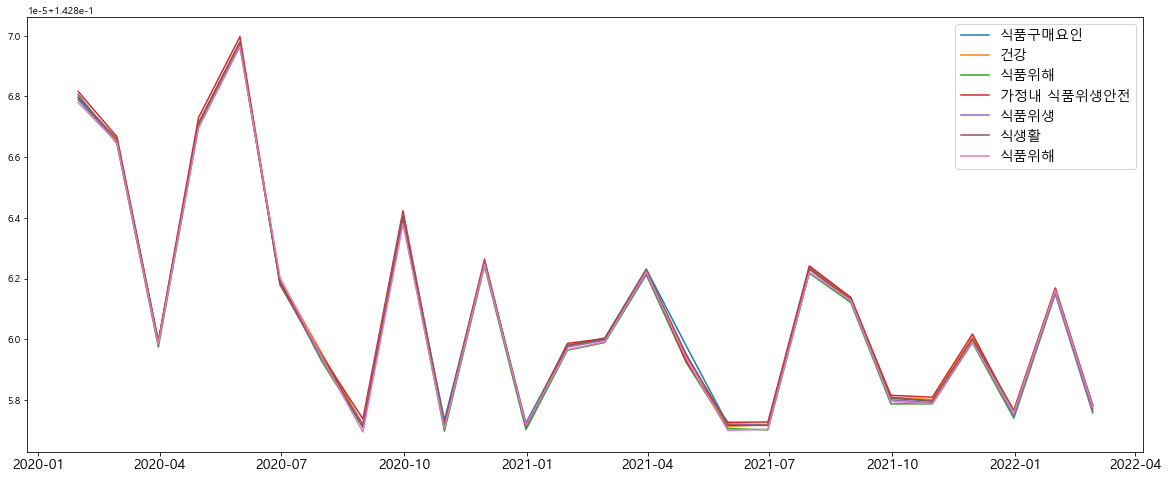

In [35]:
from scipy.ndimage import gaussian_filter1d
gd = pd.DataFrame(gaussian_filter1d(trend_data, 10))
gd.index = trend_data.index

plt.figure(figsize=(20, 8))
plt.plot(gd)

#plt.legend(labels=('Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6'), loc='best')
plt.legend(labels=('식품구매요인', '건강', '식품위해', '가정내 식품위생안전', '식품위생', '식생활','식품위해')
           , fontsize= 14, loc='best')
plt.xticks(fontsize=14)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1.42704095, 2.06782203, 3.        , 3.93217797, 4.57295905])

array([2.91948343, 2.95023502, 3.        , 3.04976498, 3.08051657])

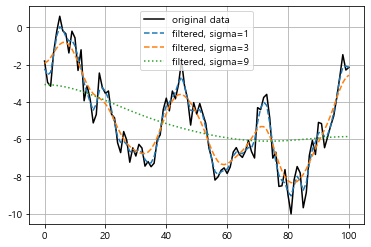

In [36]:
gaussian_filter1d([1.0, 2.0, 3.0, 4.0, 5.0], 1)
#array([ 1.42704095,  2.06782203,  3.        ,  3.93217797,  4.57295905])
gaussian_filter1d([1.0, 2.0, 3.0, 4.0, 5.0], 4)
#array([ 2.91948343,  2.95023502,  3.        ,  3.04976498,  3.08051657])
import matplotlib.pyplot as plt
rng = np.random.default_rng()
x = rng.standard_normal(101).cumsum()
y1 = gaussian_filter1d(x, 1)
y3 = gaussian_filter1d(x, 3)
y6 = gaussian_filter1d(x, 6)
y9 = gaussian_filter1d(x, 20)
plt.plot(x, 'k', label='original data')
plt.plot(y1, '--', label='filtered, sigma=1')
plt.plot(y3, '--', label='filtered, sigma=3')
#plt.plot(y6, ':', label='filtered, sigma=6')
plt.plot(y9, ':', label='filtered, sigma=9')
plt.legend()
plt.grid()
plt.show()

### 혼란도와 토픽 응집도를 이용한 최적값 선택

In [153]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-9.852902070104767


num_topics: 3, perplexity: -6.802, coherence: -8.651
num_topics: 4, perplexity: -6.849, coherence: -9.754
num_topics: 5, perplexity: -6.899, coherence: -9.997
num_topics: 6, perplexity: -6.893, coherence: -10.784
num_topics: 7, perplexity: -6.951, coherence: -10.717
num_topics: 8, perplexity: -6.934, coherence: -11.329
num_topics: 9, perplexity: -6.995, coherence: -12.180
num_topics: 10, perplexity: -7.054, coherence: -12.585
num_topics: 11, perplexity: -7.139, coherence: -12.531
num_topics: 12, perplexity: -7.275, coherence: -12.994
num_topics: 13, perplexity: -7.692, coherence: -12.405
num_topics: 14, perplexity: -8.629, coherence: -12.342
num_topics: 15, perplexity: -9.835, coherence: -12.296


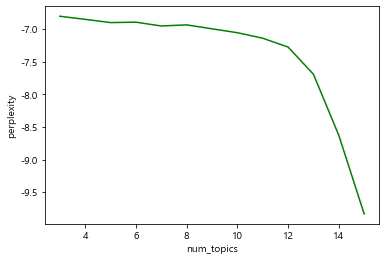

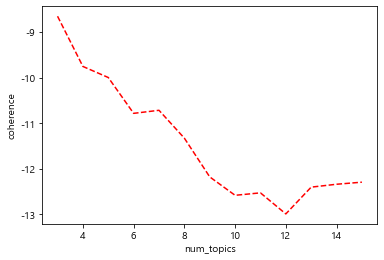

In [154]:
def show_coherence(corpus, dictionary, start=3, end=10):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=3, end=15)

# <font color='red'> 사이킷런 LDA
## 불용어를 Countvector()에서 적용

## 특성추출(가중치순 상위 50개)로 corpus 새로이 구성

In [77]:
corpus = []

for keywords in tf['특성추출(가중치순 상위 50개)']:
    corpus.append(keywords)

corpus[:2]

['시범판매,밀가루,농산물,밀산업,자급률,병해충,소비자,육성법,소비량,신규제품,16톤,웰빙,농림축산식품부,로컬푸드,kg,발전대책',
 '아쿠아포닉스,고창군,고창군청,지원사업,이영성,아쿠아포닉스코리아,재배법,수경재배,환경오염,이영윤,미래농업,농어촌,화학비료,전라북도,물고기양식,융복합,농산물,소비자,유기물,무농약,합성어,식감,양식장,아쿠포닉스,농특산물,노지']

### 불용어 적용

In [78]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
vect = CountVectorizer(stop_words = stop_words, ngram_range=(1, 2), min_df= 0.0015, max_df= 0.9)
X = vect.fit_transform(corpus) # Doc-Term Matrix 계산
len(vect.get_feature_names())
X

#from scipy import sparse
#X.toarray()
#sparse.csr_matrix(X.toarray())
#pd.DataFrame(X.toarray(), columns = vect.get_feature_names())

116

<474591x116 sparse matrix of type '<class 'numpy.int64'>'
	with 262506 stored elements in Compressed Sparse Row format>

In [79]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=7, random_state=42)
lda.fit(X)
# components_속성은 토픽별(row)로 1000개의 feature(단어)들의 분포수치(column)를 보여줌
print(lda.components_.shape)
print(lda.components_)

LatentDirichletAllocation(n_components=7, random_state=42)

(7, 116)
[[1.01714281e+03 1.42863484e-01 1.42927230e-01 1.42969896e-01
  7.78142842e+02 1.42941728e-01 1.42972747e-01 1.42868005e-01
  1.42875532e-01 1.42891757e-01 1.42862756e-01 1.42958467e-01
  2.65614251e+03 1.42938697e-01 1.42884231e-01 1.42878968e-01
  1.42905144e-01 1.42903601e-01 2.00745774e+03 1.43201636e-01
  6.77693369e+02 1.42985898e-01 1.23214275e+03 1.42960937e-01
  1.83995675e-01 1.42952125e-01 1.42991717e-01 1.43237295e-01
  1.42958646e-01 1.48023483e+03 9.94855785e+01 1.43076342e-01
  1.42980235e-01 1.42980985e-01 1.01814277e+03 9.46142561e+02
  1.45805881e-01 1.46061794e-01 1.42917012e-01 1.42916548e-01
  9.61142426e+02 1.42923434e-01 2.25446050e+03 8.14142777e+02
  1.42943994e-01 1.42923501e-01 1.42861927e-01 3.10586957e-01
  1.42909711e-01 1.43122049e-01 1.42900724e-01 1.43020948e-01
  1.42933857e-01 1.43795737e+03 1.42885076e-01 2.17115224e+02
  1.43198195e-01 1.42868735e-01 1.42919058e-01 1.42873749e-01
  1.42957352e-01 1.43071590e-01 1.42925757e-01 1.42900508e-01

In [80]:
# 이 때 lda_model이란, 벡터화시킨 텍스트 데이터를 fit까지만 적용한 모델!
def display_topic_words(lda_model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(lda_model.components_):
        print('\nTopic #', topic_idx+1)
        
        # Topic별로 1000개의 단어들(features)중에서 높은 값 순으로 정렬 후 index를 반환해줌!
        # argsort()는 디폴트가 오름차순임(1,2,3,...) 그래서 [::-1]로 내림차순으로 바꿔주기
        topic_word_idx = topic.argsort()[::-1]
        top_idx = topic_word_idx[:num_top_words]
        
        # CountVectorizer함수 할당시킨 객체에 get_feature_names()로 벡터화시킨 feature(단어들)볼 수 있음!
        # 이 벡터화시킨 단어들(features)은 숫자-알파벳순으로 정렬되며, 단어들 순서는 fit_transform시키고 난 이후에도 동일!
        # '문자열'.join 함수로 특정 문자열 사이에 끼고 문자열 합쳐줄 수 있음.
        feature_concat = '+'.join([str(feature_names[i])+'*'+str(round(topic[i], 1)) for i in top_idx])
        print(feature_concat)    
        
feature_names = vect.get_feature_names()
display_topic_words(lda, feature_names, 15)


Topic # 1
곰팡이*2656.1+돼지고기*2254.5+농가*2007.5+축산물*1722.9+축산*1649.1+지하수*1489.1+농업*1480.2+원재료*1479.1+생산자*1438.0+농림*1232.1+조류인플루엔자*1177.1+아프리카돼지열병*1043.1+농장*1018.1+asf*1017.1+닭고기*961.1

Topic # 2
안전성*7577.1+오염수*6168.9+건강기능식품*3727.0+급식*2243.5+유산균*1975.8+특산물*1651.1+추출물*1392.1+건강식품*1360.1+오염물질*1323.1+농기계*1275.1+농약*1105.1+프로바이오틱스*1090.1+비건*1040.1+농축수산물*993.5+건기식*816.1

Topic # 3
소상공인*6523.1+친환경*5138.1+농산물*2610.5+냉장고*2052.1+농작물*1898.1+가공식품*1519.1+소고기*1473.1+농민들*1349.1+식료품*1263.1+유해물질*914.2+화학물질*806.1+고춧가루*788.1+농가들*775.1+한국농어촌공사*737.1+학교급식*475.6

Topic # 4
온라인*29783.1+미생물*3170.9+건강관리*2327.1+대장균*1751.4+간편식*1588.1+밀키트*988.1+신선식품*872.3+포도상구균*864.6+식감*809.0+주류*754.1+소고기*0.1+cj제일제당*0.1+농특산물*0.1+항바이러스*0.1+농축산물*0.1

Topic # 5
식재료*3299.2+중금속*2857.1+음식물*2460.1+위생*2284.1+식생활*1655.1+이물질*1544.1+급식소*1473.1+생수*1326.1+정수기*1277.1+바이러스*1186.1+식습관*1150.1+발암물질*1080.1+영양소*940.6+식중독*936.7+위생관리*883.3

Topic # 6
수산물*9928.1+축산물*5044.9+음식점*4948.1+식중독*2534.5+원산지*2393.1+해수부*1826.1+해양수산부*1560.1+농어촌*1485.1+유통기한*1153.0+스마트팜*

In [81]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] 
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_top_words(lda, vect.get_feature_names(), 20)

Topic #0: 곰팡이, 돼지고기, 농가, 축산물, 축산, 지하수, 농업, 원재료, 생산자, 농림, 조류인플루엔자, 아프리카돼지열병, 농장, asf, 닭고기, 농촌, 돼지열병, 축산농가, 가금농장, 농경지
Topic #1: 안전성, 오염수, 건강기능식품, 급식, 유산균, 특산물, 추출물, 건강식품, 오염물질, 농기계, 농약, 프로바이오틱스, 비건, 농축수산물, 건기식, 영양제, 항산화, 섭취량, 농축산물, 건강
Topic #2: 소상공인, 친환경, 농산물, 냉장고, 농작물, 가공식품, 소고기, 농민들, 식료품, 유해물질, 화학물질, 고춧가루, 농가들, 한국농어촌공사, 학교급식, 농축수산물, 농경지, 농축산물, 축산물, 돼지고기
Topic #3: 온라인, 미생물, 건강관리, 대장균, 간편식, 밀키트, 신선식품, 포도상구균, 식감, 주류, 소고기, cj제일제당, 농특산물, 항바이러스, 농축산물, 특산물, 농식품, 첨가물, 한국농수산식품유통공사, 건강식품
Topic #4: 식재료, 중금속, 음식물, 위생, 식생활, 이물질, 급식소, 생수, 정수기, 바이러스, 식습관, 발암물질, 영양소, 식중독, 위생관리, cj제일제당, 무상급식, 짜파구리, 영양사, 급식비
Topic #5: 수산물, 축산물, 음식점, 식중독, 원산지, 해수부, 해양수산부, 농어촌, 유통기한, 스마트팜, 농수산물, 수산업, 김밥, 음식, 아이스크림, 대장균, bpa, 위생법, 밥상, 양식장
Topic #6: 농산물, 농업인, 단백질, 면역력, 건강, 농식품, 한국농수산식품유통공사, 로컬푸드, 첨가물, 농축산물, 생산자, 화합물, 농업인들, 농특산물, 항바이러스, 농업기술센터, 영양소, 농수산물, 식감, 추출물


In [82]:
# transform까지 수행하면, 문서별(row)로 토픽들(column)의 분포를 알려줌
doc_topics = lda.transform(X)
print(doc_topics.shape)
print(doc_topics[:10])

(474591, 7)
[[0.04761905 0.04761905 0.04765321 0.04761905 0.04761905 0.04761905
  0.71425155]
 [0.02380952 0.02380952 0.02382039 0.0239096  0.02380952 0.35714288
  0.52369856]
 [0.03571429 0.03571429 0.03573991 0.2857138  0.03571429 0.03571429
  0.53568915]
 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
  0.57142857]
 [0.04761905 0.38095232 0.04761905 0.04761905 0.04761905 0.04761905
  0.38095244]
 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
  0.57142857]
 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
  0.57142857]
 [0.0357291  0.03571429 0.03573059 0.03571429 0.03571429 0.03571429
  0.78568316]
 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.57142857
  0.07142857]
 [0.04761905 0.38095232 0.04761905 0.04761905 0.04761905 0.04761905
  0.38095244]]


Text(0.5, 1.0, '0')

Text(0.5, 1.0, '1')

Text(0.5, 1.0, '2')

Text(0.5, 1.0, '3')

Text(0.5, 1.0, '4')

Text(0.5, 1.0, '5')

Text(0.5, 1.0, '6')

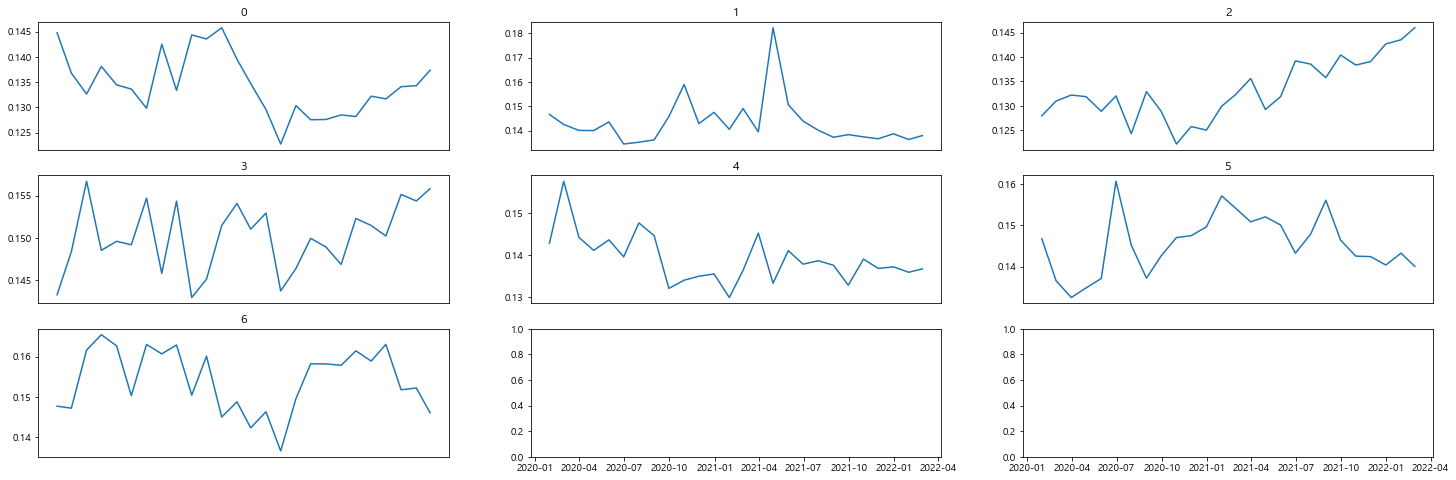

In [91]:
trend_data = pd.DataFrame(doc_topics)
trend_data['start'] = tf['일자'].values
trend_data = trend_data.set_index('start')
trend_data = trend_data.resample('M').mean()

fig, axes = plt.subplots(3, 3, sharex='col', figsize=(25, 8)) 
for col, ax in zip(trend_data.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend_data[col])
plt.show()

<Figure size 1440x360 with 0 Axes>

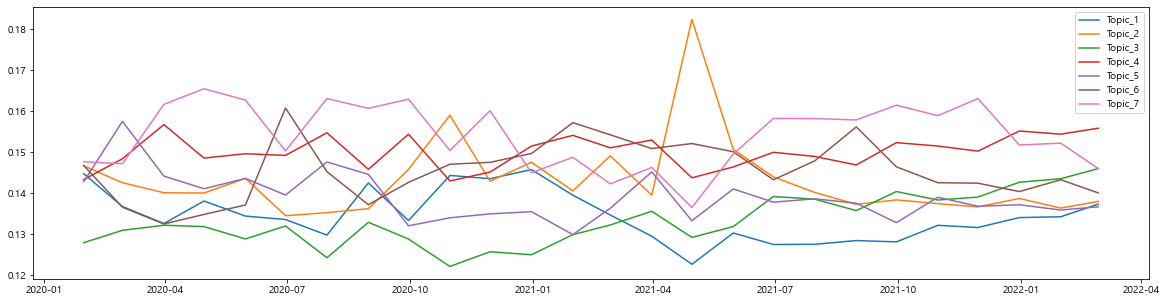

In [90]:
plt.figure(figsize=(20, 5))
plt.plot(trend_data)
plt.legend(labels=('Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7'), loc='best')

In [92]:
#X = TfidfTransformer().fit_transform(X)

count = X.toarray().sum(axis=0) # Doc-Term Matrix 각 단어에 대한 합

#count = np.random.permutation(X.toarray()).sum(axis=0) 행으로 permutation하여도 상관없음
idx = np.argsort(-count)
count = count[idx]

feature_name = np.array(vect.get_feature_names())[idx]
len(feature_name)
feature_name
len(count)

116

array(['온라인', '농산물', '수산물', '안전성', '축산물', '소상공인', '농업인', '오염수', '친환경',
       '단백질', '음식점', '면역력', '건강기능식품', '건강', '식중독', '식재료', '미생물', '농식품',
       '중금속', '생산자', '대장균', '곰팡이', '음식물', '원산지', '돼지고기', '건강관리', '위생',
       '급식', '냉장고', '농가', '유산균', '농작물', '해수부', '한국농수산식품유통공사', '농축산물',
       '특산물', '식생활', '추출물', '축산', '농수산물', '간편식', '영양소', '로컬푸드', '해양수산부',
       '이물질', '가공식품', '지하수', '농어촌', '농업', '원재료', '소고기', '급식소', '첨가물',
       '건강식품', '유통기한', '농민들', '생수', '오염물질', '농축수산물', '정수기', '농기계', '식료품',
       '유해물질', '식감', '농림', '바이러스', '조류인플루엔자', '화합물', '농업인들', '식습관',
       '스마트팜', '학교급식', '농약', '프로바이오틱스', '농특산물', '발암물질', '수산업', '아프리카돼지열병',
       '비건', '농장', 'asf', '밥상', '항바이러스', '밀키트', '김밥', '음식', '아이스크림',
       '닭고기', '농촌', '농업기술센터', 'bpa', '농경지', '위생관리', '위생법', '신선식품',
       '포도상구균', 'cj제일제당', '무상급식', '건기식', '돼지열병', '축산농가', '짜파구리', '화학물질',
       '영양사', '고춧가루', '항산화', '가금농장', '농가들', '양식장', '알레르기', '주류', '영양제',
       '급식비', '한국농어촌공사', '외식업', '섭취량'], dtype='<U11')

116

# End

### <font color='brown'>  부록
- 'D:\\기본과제\\script'의 2022_05_cosine similarity_bicoclustering_practice 로 확인하던지 K-means로 확인하면 됨

In [94]:
from sklearn.cluster import SpectralBiclustering, SpectralCoclustering
from sklearn.preprocessing import normalize
cosinematrix_ = cosinematrix.copy()

In [112]:
cosinematrix_.isna().sum().sum()
cosinematrix_.info()
cosinematrix_

0

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 밀가루 to 남성호르몬
Columns: 239 entries, 밀가루 to 남성호르몬
dtypes: float32(239)
memory usage: 225.0+ KB


,밀가루,농산물,웰빙,로컬푸드,항산화,농업인,생산자,하나로마트,농업,식물,...,심낭염,모더나사,축산물공판장,수제맥주,알레르기,첨가물,중금속,축산물,여성호르몬,남성호르몬
밀가루,1.00,0.95,0.99,0.97,0.97,0.96,0.98,0.99,0.92,1.00,...,0.99,0.99,1.00,1.00,1.00,1.00,0.98,0.98,0.99,0.99
농산물,0.95,1.00,0.90,0.99,0.87,0.98,0.99,0.97,0.95,0.96,...,0.95,0.94,0.96,0.95,0.94,0.93,0.89,0.99,0.93,0.93
웰빙,0.99,0.90,1.00,0.94,1.00,0.92,0.95,0.98,0.89,0.98,...,0.98,0.98,0.98,0.98,0.99,1.00,1.00,0.94,0.99,0.99
로컬푸드,0.97,0.99,0.94,1.00,0.91,0.98,0.99,0.99,0.94,0.98,...,0.97,0.96,0.98,0.97,0.97,0.96,0.93,0.99,0.96,0.96
항산화,0.97,0.87,1.00,0.91,1.00,0.89,0.92,0.95,0.86,0.97,...,0.96,0.97,0.96,0.97,0.97,0.99,1.00,0.91,0.98,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
첨가물,1.00,0.93,1.00,0.96,0.99,0.94,0.97,0.99,0.91,0.99,...,0.99,0.99,0.99,0.99,0.99,1.00,0.99,0.96,1.00,0.99
중금속,0.98,0.89,1.00,0.93,1.00,0.92,0.94,0.97,0.88,0.98,...,0.97,0.98,0.97,0.98,0.98,0.99,1.00,0.93,0.99,0.99
축산물,0.98,0.99,0.94,0.99,0.91,0.98,1.00,0.99,0.95,0.98,...,0.98,0.97,0.98,0.97,0.97,0.96,0.93,1.00,0.96,0.96
여성호르몬,0.99,0.93,0.99,0.96,0.98,0.95,0.97,0.99,0.92,0.99,...,0.98,0.99,0.99,0.99,0.99,1.00,0.99,0.96,1.00,1.00


In [111]:
sns.set_style("white")
sns.set(rc = {'figure.figsize':(20,12)})

i = 1

for i, n in enumerate(np.arange(2, 6)):
    i +=1
    model = SpectralCoclustering(n_clusters=n, random_state=1)
    model.fit(cosinematrix_)

    ax = plt.subplot(3, 6, i)
    ax.matshow(
        np.outer(np.sort(model.row_labels_) + 1, np.sort(model.column_labels_) + 1),
        cmap=plt.cm.Blues,
    )
    ax.set_title(str(n) + " Clusters")
    i += 1    

AttributeError: 'NoneType' object has no attribute 'split'